## Введение.

Какой кейс решаем?

Кейс для дата-сайентиста в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

Поставлена задача создать такую модель.

Первоначальный датасет содержит 17 полей с данными:

* `hotel_address` - адрес отеля
* `review_date` - дата, когда рецензент разместил соответствующий отзыв.
* `average_score` - средний балл отеля, рассчитанный на основе последнего комментария за последний год
* `hotel_name` - название отеля
* `reviewer_nationality` - национальность рецензента
* `negative_review` - отрицательный отзыв, который рецензент дал отелю.
* `review_total_negative_word_counts` - общее количество слов в отрицательном отзыв
* `positive_review` - положительный отзыв, который рецензент дал отелю
* `review_total_positive_word_counts` - общее количество слов в положительном отзыве
* `reviewer_score` - оценка, которую рецензент поставил отелю на основе своего опыта
* `total_number_of_reviews_reviewer_has_given` - количество отзывов, которые рецензенты дали в прошлом
* `total_number_of_reviews` - общее количество действительных отзывов об отеле
* `tags` - теги, которые рецензент дал отелю.
* `days_since_review` - продолжительность между датой проверки и датой очистки
* `additional_number_of_scoring` - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* `lat` - широта отеля
* `lng` - долгота отеля

## Загрузка данных.

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем инструменты для работы с моделью:
from sklearn.model_selection import train_test_split # разделение датасета
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
from sklearn.feature_selection import chi2, f_classif #сравнение выборок

# различные инструменты
from colorama import Style
import warnings
warnings.filterwarnings('ignore')
import re
import category_encoders as ce
from scipy.stats import normaltest, shapiro
from sklearn import preprocessing

In [7]:
# константы
RANDOM_SEED = 42
DATA_DIR = './data/'


In [8]:
# фиксируем версию пакетов для воспроизводимости
!pip freeze > requirements.txt

In [9]:
# загружаем данные из соревнования
df_train = pd.read_csv(DATA_DIR+'/hotels_train.zip') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.zip') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.zip') # сабмишн

In [10]:
df_train[:4]

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540


In [11]:
df_test[:4]

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298


In [12]:
sample_submission[:4]

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352


In [13]:
df_train.shape

(386803, 17)

In [14]:
df_test.shape

(128935, 16)

In [15]:
sample_submission.shape

(128935, 2)

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [17]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [18]:
df_train.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng
count,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.00000,386803.000000,384355.000000,384355.000000
mean,498.246536,8.397231,18.538988,2743.992042,17.776985,7.17725,8.396906,49.443522,2.823402
std,500.258012,0.547881,29.703369,2316.457018,21.726141,11.05442,1.636090,3.466936,4.579043
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.00000,2.500000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.00000,7.500000,48.214662,-0.143649
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.00000,8.800000,51.499981,-0.000250
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.00000,9.600000,51.516288,4.834443
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.00000,10.000000,52.400181,16.429233


In [19]:
df_train.describe(include='object')

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,386803,386803,386803,386803,386803,386803,386803,386803
unique,1493,731,1492,225,248828,311737,47135,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,3587,1911,3587,184033,95907,26885,3853,1911


## Разведочный анализ

### Проектирование признаков

Проанализируем целевую переменную

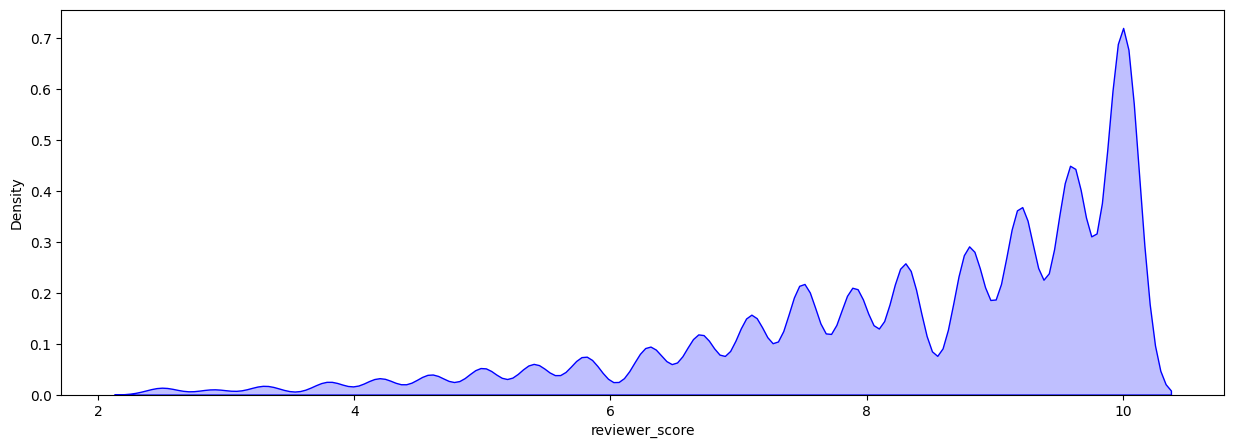

In [20]:
plt.figure(figsize=(15,5))
sns.kdeplot(df_train['reviewer_score'], fill=True, color='blue')
plt.show;

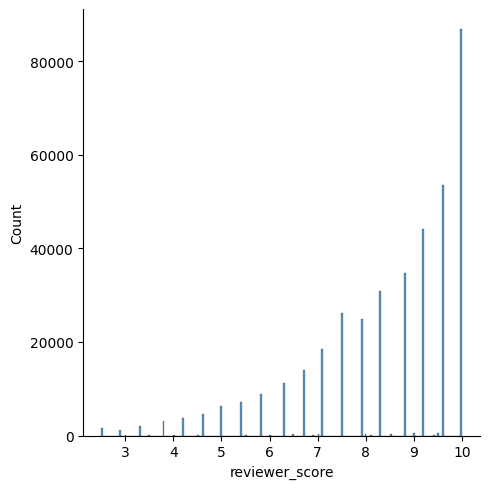

In [21]:
sns.displot(df_train['reviewer_score'], bins=200);

Между основными значениями есть какие-то "пеньки" в данных, попробую проанализировать. 

Часть системы оценивания booking.com, которая непосредственно преабразуется в score, представляет из себя 6 пунктов, где клиенту предлагается на выбор 4 градации по 10 баллов в виде смайликов. Итоговая оценка расчитывается самой системой и расчитывается как среднее арифметическое с округлением до десятых. 
Так как "пеньков" в наших данных немного, я удалю их - скорее всего это шум, вызванный какими-то сбоями. Будем считать шумом оценки количеством менее 1000 (опытным путем).

In [22]:
df_train['reviewer_score'].value_counts()

10.0    86803
9.6     53502
9.2     44053
8.8     34795
8.3     30903
7.5     26164
7.9     24901
7.1     18529
6.7     14117
6.3     11244
5.8      8962
5.4      7082
5.0      6278
4.6      4660
4.2      3827
3.8      3017
3.3      2063
2.5      1632
2.9      1211
9.5       523
9.0       483
8.0       388
8.5       379
7.0       293
6.5       274
6.0       184
5.5       161
4.5        97
4.0        66
3.5        61
9.4        47
8.1        28
3.0        25
6.9        23
5.6        13
4.4         9
3.1         6
Name: reviewer_score, dtype: int64

In [23]:
df_train = df_train.query(
    'reviewer_score not in [9.5, 9.0, 8.0, 8.5, 7.0, 6.5, 6.0, 5.5, 4.5, 4.0, 3.5, 9.4, 8.1, 3.0, 6.9, 5.6, 4.4, 3.1]'
)
df_train['reviewer_score'].value_counts().sort_index(ascending=False)


10.0    86803
9.6     53502
9.2     44053
8.8     34795
8.3     30903
7.9     24901
7.5     26164
7.1     18529
6.7     14117
6.3     11244
5.8      8962
5.4      7082
5.0      6278
4.6      4660
4.2      3827
3.8      3017
3.3      2063
2.9      1211
2.5      1632
Name: reviewer_score, dtype: int64

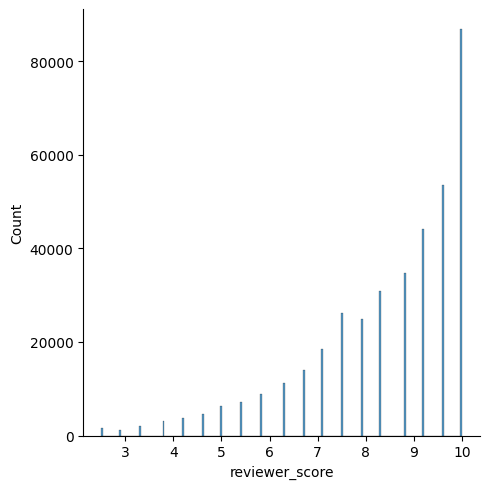

In [24]:
# результирующая гистограмма
sns.displot(df_train['reviewer_score'], bins=200);

Проверим дубликаты в `df_train` - до объединения датасетов их можно удалить

In [25]:
mask = df_train.duplicated()
df_train_duplicates = df_train[mask]
print(f'Число найденных дубликатов: {df_train_duplicates.shape[0]}')

Число найденных дубликатов: 306


In [26]:
# удалим дубликаты
df_train.drop_duplicates(inplace=True, ignore_index=True)
df_train.shape

(383437, 17)

Объединяем датасеты

In [27]:
df_train['sample'] = 1 # помечаем трейн
df_test['sample'] = 0 # помечаем тест
df_test['reviewer_score'] = 0 # заполняем значения reviewer_score нулями в тест

# объединяем
data = df_test.append(df_train, sort=False).reset_index(drop=True)

Распределения числовых признаков

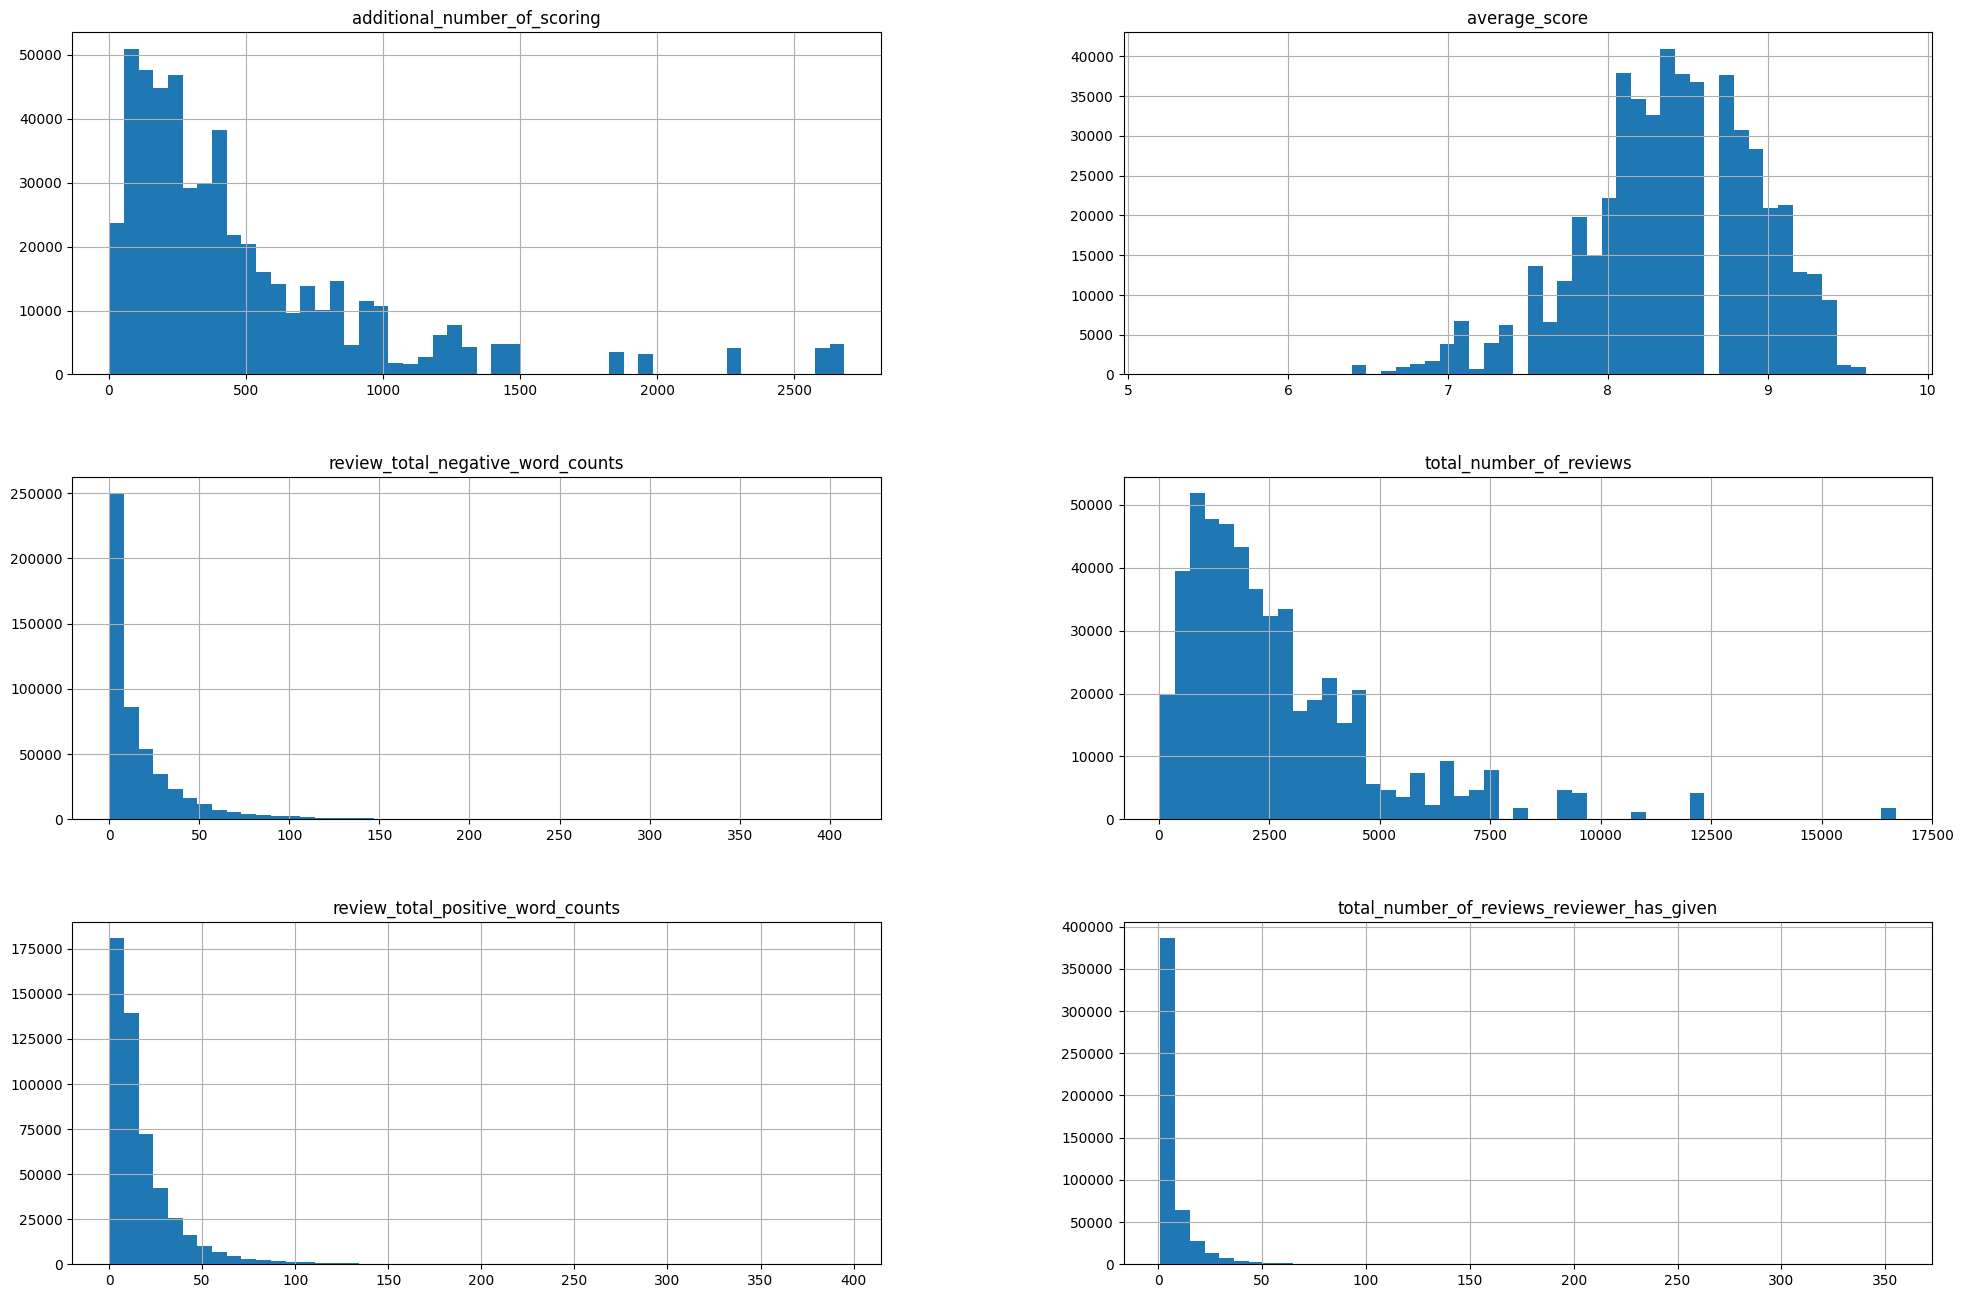

In [28]:
# Построим гистограммы для числовых признаков, исключив неинформативные признаки
num_cols = ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts',
               'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given']
data[num_cols].hist(figsize=(24,16), bins=50);

In [29]:
# прологарифмируем num_cols и добавим в датафрейм
for i in num_cols:
    data['log_'+i] = np.log(data[i]+1)

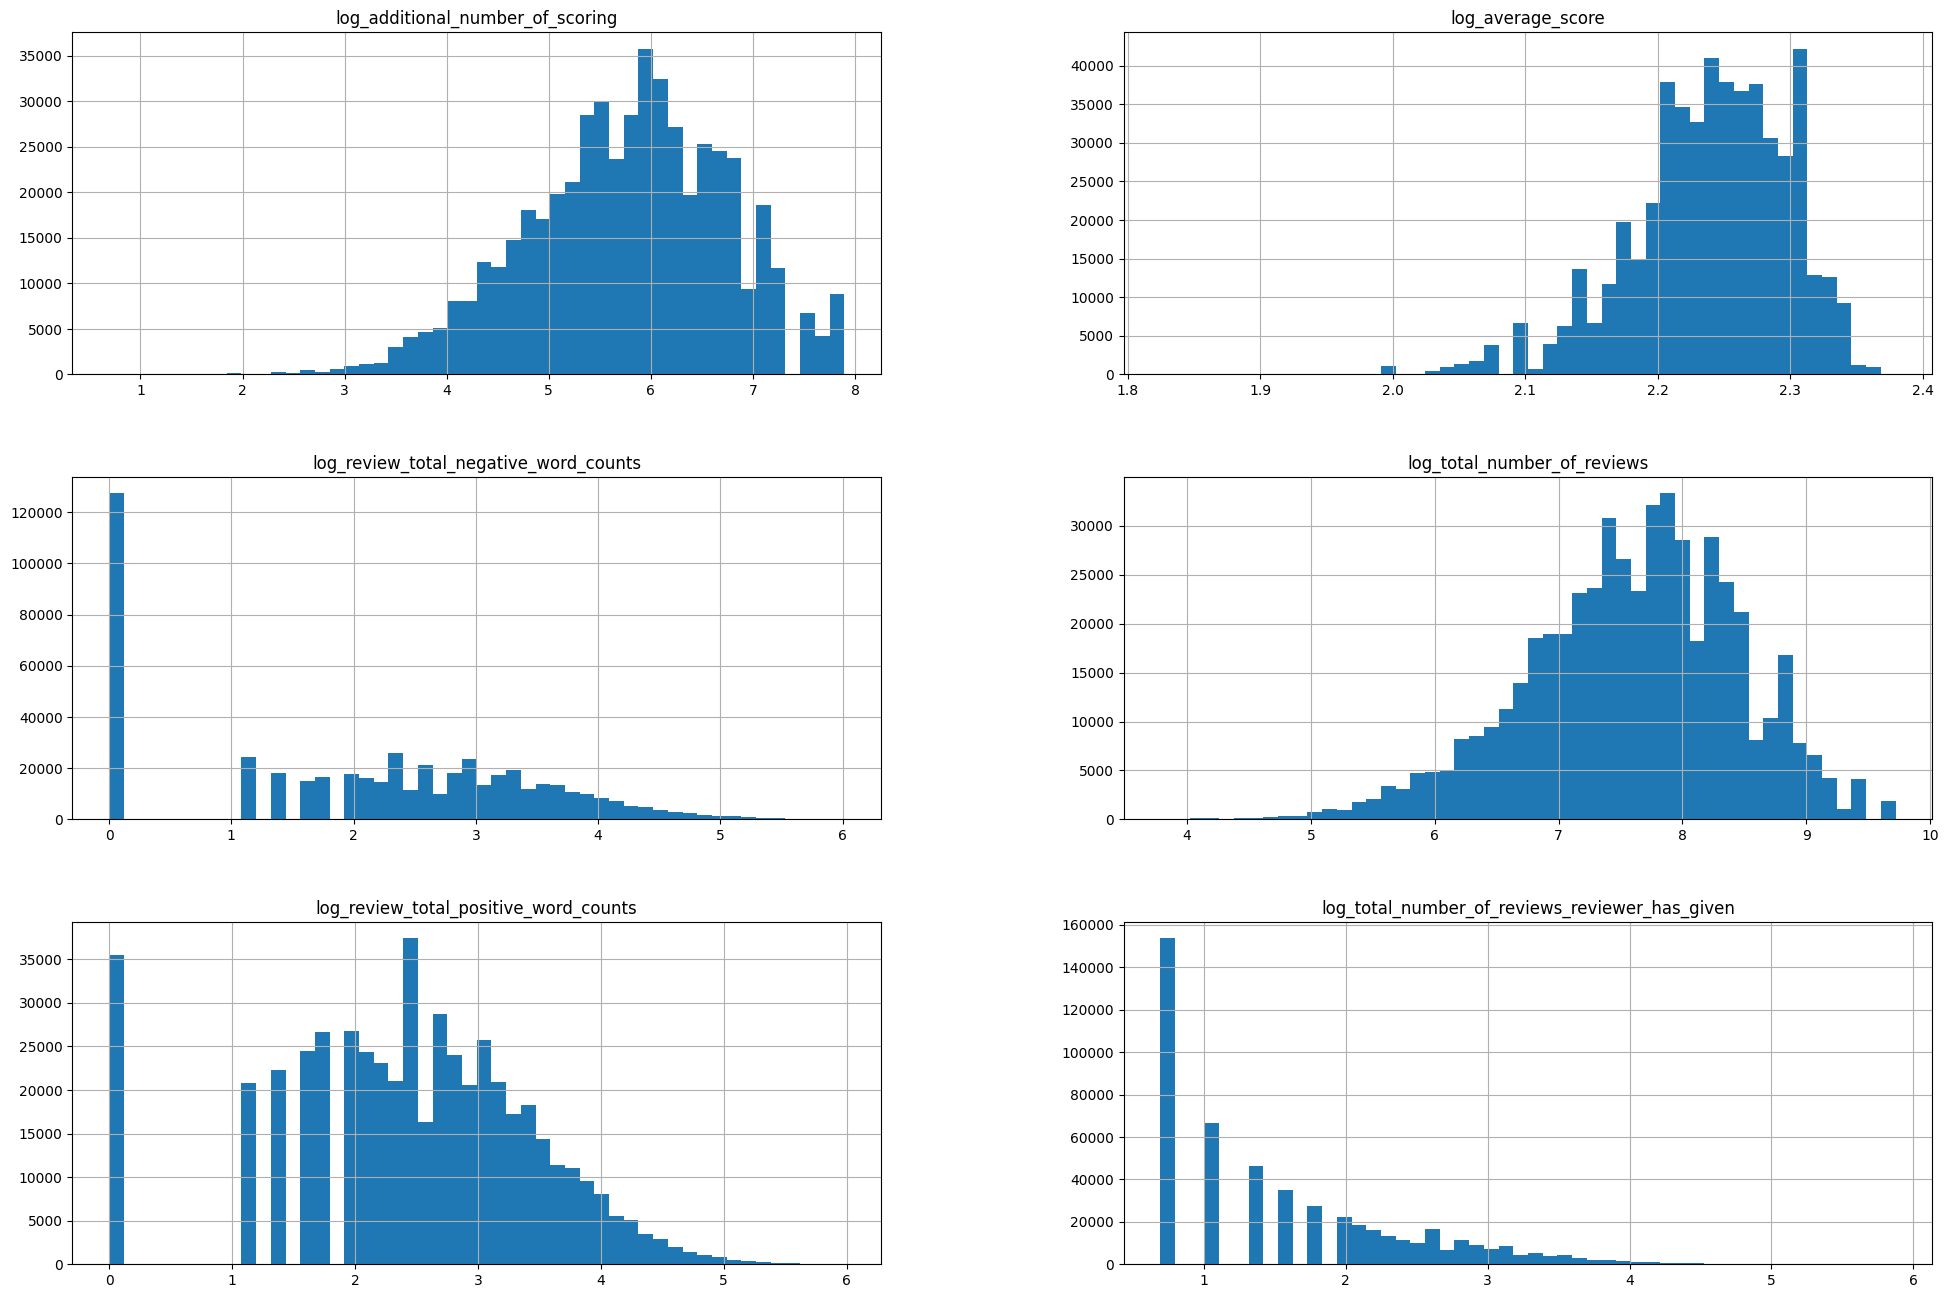

In [30]:
log_num_cols = ['log_additional_number_of_scoring', 'log_average_score', 'log_review_total_negative_word_counts',
               'log_total_number_of_reviews', 'log_review_total_positive_word_counts', 'log_total_number_of_reviews_reviewer_has_given']
data[log_num_cols].hist(figsize=(24,16), bins=50);

убедимся, что количество слов, равное 0 в `review_total_negative_word_counts` и в `review_total_positive_word_counts` совпадает с `No Negative` и `No Positive` в отзывах:

In [31]:
data[data['review_total_negative_word_counts'] == 0].shape[0] == data[data['negative_review'] == 'No Negative'].shape[0]

True

In [32]:
data[data['review_total_positive_word_counts'] == 0].shape[0] == data[data['positive_review'] == 'No Positive'].shape[0]

True

Гипотеза подтвердилась, а раз так, то нулевые значения количества слов в негативных отзывах означает как раз обратное - негатива нет. Аналогично с позитивными отзывами. Более подробно рассмотрим это дальше.

Посмотрим, как влияет количество слов на целевую переменную.


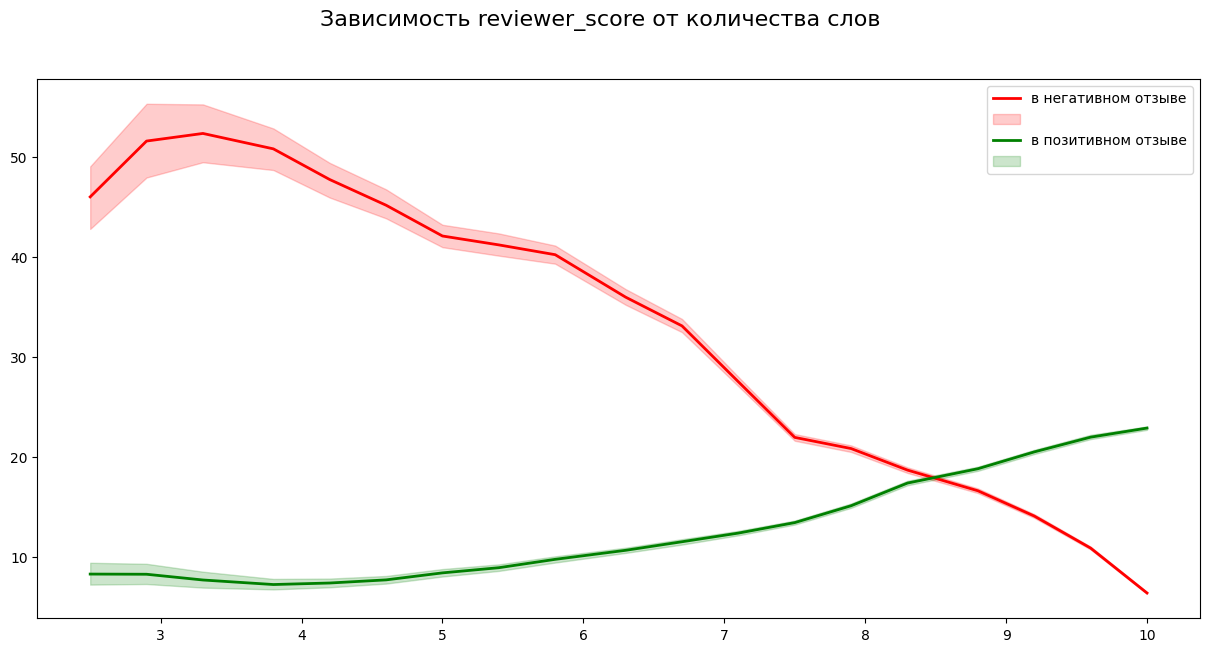

In [33]:
mask = data['sample'] == 1
mask2 = data['negative_review'] != 'No Negative'

fig, ax = plt.subplots(figsize=(15, 7))
plt.suptitle('Зависимость reviewer_score от количества слов', size=16)
count_neg = sns.lineplot(
    data=data[mask],
    x='reviewer_score',
    y='review_total_negative_word_counts',
    color='red', linewidth=2
)

count_pos = sns.lineplot(
    data=data[mask],
    x='reviewer_score',
    y='review_total_positive_word_counts',
    color='green', linewidth=2
)

ax.set_xlabel('')
ax.set_ylabel('')
ax.legend(['в негативном отзыве', '', 
           'в позитивном отзыве', ''
           ],loc='upper right', fontsize=10);


Для негативных отзывов: чем ниже оценка, тем больше слов в отзыве; для позитивных отзывов зависимость обратная: чем выше оценка, тем больше слов в отзыве. 

Из адреса сформируем новые признаки: `country`- страна, `city` - город, `postcode` - индекс. 
В википедии есть информация по формированию индексов во всех странах, которые представлены в датасете, воспользуемся ей для составления регулярных выражений для индекса.

In [34]:
# Функция для формирования 'postcode' из адреса
def get_post_code(st):
    post_code = None
    if 'Kingdom' in st:
        post_code = re.findall(r'[A-Z]\w{1,3}\s\d\w{1,3}', st)
    else:
        post_code = re.findall(r'\d{4,}', st)
        
    return post_code[0]

# Формируем 'postcode' из адреса
data['postcode'] = data['hotel_address'].apply(get_post_code)

# Формируем 'country' из адреса
data['country'] = data['hotel_address'].apply(lambda x: x.split()[-1] \
    if x.split()[-1] != 'Kingdom' else 'United Kingdom')
# Формируем 'city' из адреса
data['city'] = data['hotel_address'].apply(lambda x: x.split()[-2] \
    if x.split()[-2] != 'United' else x.split()[-5])


In [35]:
# убедимся, что в новых признаках нет пропусков
data[['country', 'city', 'postcode']].isnull().sum()

country     0
city        0
postcode    0
dtype: int64

Проверим гипотезу, что в каждой стране представлен только один город

In [36]:
group_country = data.groupby(['country', 'city'])[['country', 'city']].count()
group_country

,,country,city
country,city,,
Austria,Vienna,38737,38737
France,Paris,59311,59311
Italy,Milan,36984,36984
Netherlands,Amsterdam,56898,56898
Spain,Barcelona,59828,59828
United Kingdom,London,260614,260614


Гипотеза подтвердилась, следовательно признак 'city' будет дублировать информацию 'country', впоследствии удалим его

Посмотрим, сколько отелей имеют пропуски в широте и долготе

In [37]:
hotels_lat_lng = data[data['lat'].isna()].loc[:, 'hotel_name'].nunique()
print(f' У {hotels_lat_lng} отелей не заполнены координаты')


 У 17 отелей не заполнены координаты


Заполним недостающие координаты средним значением широт и долгот для соответствующего индекса, принадлежащему отелю с незаполненными координатами

In [38]:
# список почтовых индексов, где не заполнены координаты
empty_coord_list = data[data['lat'].isna()].loc[:, 'postcode'].unique().tolist()
# создаем словари (ключ - индекс, значение - среднее значение широты/долготы для этого индекса)
lat_dict = {}
for i in empty_coord_list:
    if i not in lat_dict:
        lat_dict[i] = data[data.postcode == '1090']['lat'].mean()
    else:
        continue
    
lng_dict = {}
for i in empty_coord_list:
    if i not in lng_dict:
        lng_dict[i] = data[data.postcode == '1090']['lng'].mean()
    else:
        continue

print(lat_dict, lng_dict)    

{'1090': 48.2198581327654, '75018': 48.2198581327654, '1080': 48.2198581327654, '1020': 48.2198581327654, '08010': 48.2198581327654, '1030': 48.2198581327654, '75008': 48.2198581327654, '75014': 48.2198581327654, '1160': 48.2198581327654, '08009': 48.2198581327654, '1190': 48.2198581327654, '1110': 48.2198581327654, '08011': 48.2198581327654} {'1090': 16.358964682437747, '75018': 16.358964682437747, '1080': 16.358964682437747, '1020': 16.358964682437747, '08010': 16.358964682437747, '1030': 16.358964682437747, '75008': 16.358964682437747, '75014': 16.358964682437747, '1160': 16.358964682437747, '08009': 16.358964682437747, '1190': 16.358964682437747, '1110': 16.358964682437747, '08011': 16.358964682437747}


In [39]:
# заполняем lat
lat_mask = data['lat'].isna()
data.loc[lat_mask, 'lat'] = data.loc[lat_mask, 'postcode'].map(lat_dict)

# заполняем lng
lng_mask = data['lng'].isna()
data.loc[lng_mask, 'lng'] = data.loc[lng_mask, 'postcode'].map(lng_dict)


In [40]:
# убедимся, что нет пропусков
data[['lat', 'lng']].isnull().sum()

lat    0
lng    0
dtype: int64

Признак `hotel_name`

In [41]:
data['hotel_name'].nunique()

1492

Названия отелей представлены 1492 уникальными значениями. Этот признак неинформативен, в последствии его можно будет удалить. 

Признак `tags`

In [42]:
data['tags']

0         [' Leisure trip ', ' Couple ', ' Double Room '...
1         [' Leisure trip ', ' Group ', ' Triple Room ',...
2         [' Business trip ', ' Solo traveler ', ' Twin ...
3         [' Leisure trip ', ' Couple ', ' Ambassador Ju...
4         [' Business trip ', ' Solo traveler ', ' Class...
                                ...                        
512367    [' Leisure trip ', ' Group ', ' Club Double or...
512368    [' Leisure trip ', ' Couple ', ' Standard Doub...
512369    [' Business trip ', ' Solo traveler ', ' Singl...
512370    [' Leisure trip ', ' Solo traveler ', ' Deluxe...
512371    [' Leisure trip ', ' Couple ', ' Bunk Bed Room...
Name: tags, Length: 512372, dtype: object

In [43]:
tags_set = set()
tags_list = list()


for index, value in data['tags'].items():
    tags = value
    tags = tags.replace('[', '').replace(']', '')
    tags = tags.replace("'", '')
    tags = tags.split(',')
    
    for i in tags:
        tags_set.add(i.strip())
        tags_list.append(i.strip())
        
# создаем объект Series для подсчета количества по каждому тегу
tags_data = pd.Series(tags_list, index=tags_list, name='tags_data')
print(f'Количество уникальных тегов: {len(tags_set)}\n')
print(f'Количество отмеченных тегов, ТОП=50: \n\n{tags_data.value_counts()[:50]}')

Количество уникальных тегов: 2427

Количество отмеченных тегов, ТОП=50: 

Leisure trip                      415202
Submitted from a mobile device    305693
Couple                            250663
Stayed 1 night                    192370
Stayed 2 nights                   133070
Solo traveler                     107723
Stayed 3 nights                    95242
Business trip                      82298
Group                              65007
Family with young children         60650
Stayed 4 nights                    47493
Double Room                        35020
Standard Double Room               32039
Superior Double Room               31171
Family with older children         26192
Deluxe Double Room                 24657
Double or Twin Room                22265
Stayed 5 nights                    20700
Standard Double or Twin Room       17386
Classic Double Room                16773
Superior Double or Twin Room       13475
2 rooms                            12302
Stayed 6 nights         

создадим новый признак - количество ночей

In [44]:
tags_data[tags_data.str.contains('night')].unique()

array(['Stayed 2 nights', 'Stayed 1 night', 'Stayed 3 nights',
       'Stayed 4 nights', 'Stayed 7 nights', 'Stayed 5 nights',
       'Stayed 6 nights', 'Stayed 14 nights', 'Stayed 12 nights',
       'Stayed 8 nights', 'Stayed 9 nights', 'Stayed 13 nights',
       'Stayed 10 nights', 'Stayed 11 nights', 'Stayed 18 nights',
       'Stayed 16 nights', 'Stayed 25 nights', 'Stayed 15 nights',
       'Stayed 19 nights', 'Stayed 23 nights', 'Stayed 26 nights',
       'Stayed 17 nights', 'Knightsbridge Suite', 'Stayed 21 nights',
       'Special Offer Double Room 3 nights minimum', 'Stayed 24 nights',
       'Stayed 29 nights', 'Stayed 20 nights', 'Stayed 22 nights',
       'Stayed 31 nights', 'King Room with Knightsbridge View',
       'Stayed 27 nights', 'Stayed 30 nights',
       'Suite with Knightsbridge View', 'Stayed 28 nights',
       'Junior Suite Give me the night'], dtype=object)

In [45]:
def get_number_nights(tags_data):
    regex = re.findall(r'\d{1,2}(?=\s?night)', tags_data)
    for i in regex:
        return np.int8(i)

# добавляем новый признак
data['count_nights'] = data['tags'].apply(get_number_nights)

data.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,log_additional_number_of_scoring,log_average_score,log_review_total_negative_word_counts,log_total_number_of_reviews,log_review_total_positive_word_counts,log_total_number_of_reviews_reviewer_has_given,postcode,country,city,count_nights
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,6.807935,2.208274,3.970292,9.721426,4.143135,0.693147,20161,Italy,Milan,2.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,6.418365,2.261763,2.397895,8.520986,0.000000,2.079442,1043,Netherlands,Amsterdam,1.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,3.850148,2.230014,1.386294,5.863631,1.791759,2.772589,08008,Spain,Barcelona,1.0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,...,5.488938,2.312535,0.000000,7.342132,3.332205,2.302585,20124,Italy,Milan,1.0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,...,6.727432,2.312535,0.000000,8.452761,2.079442,1.098612,1012,Netherlands,Amsterdam,2.0


In [46]:
# сколько пропусков в новом признаке?
data['count_nights'].isna().sum()

191

поскольку пропусков немного, не задумываясь заполним их модой количества ночей


In [47]:
data['count_nights'] = data['count_nights'].fillna(data['count_nights'].mode())

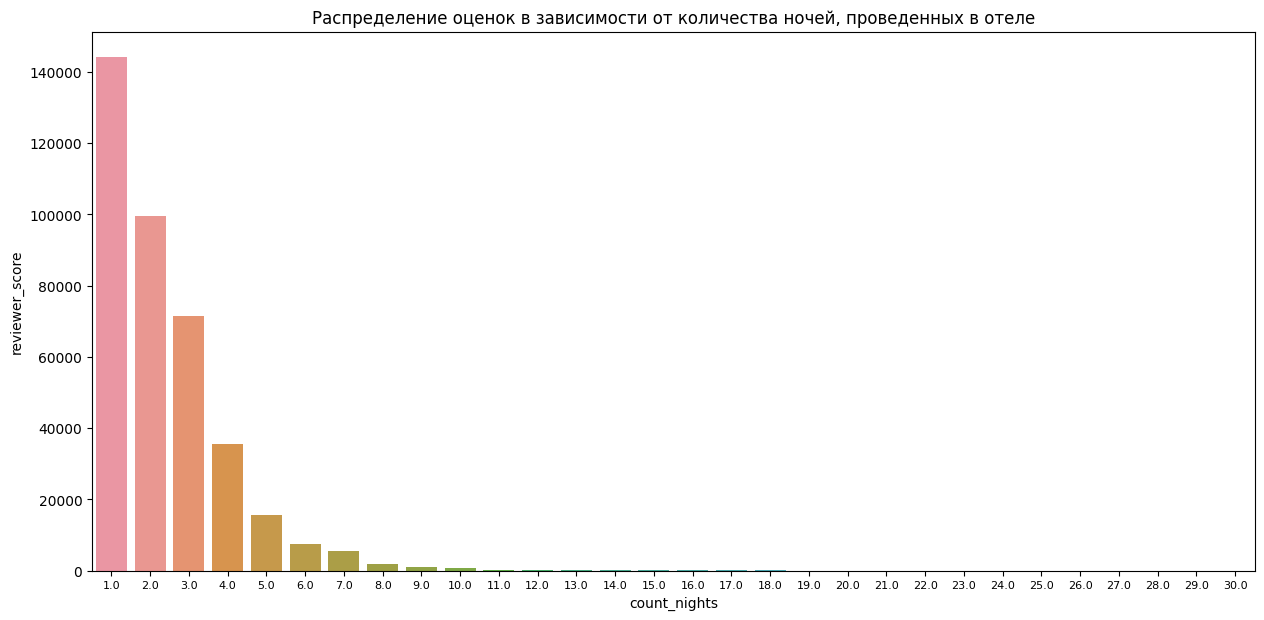

In [48]:
plt.figure(figsize=(15, 7))
sns.barplot(x='count_nights',
            y='reviewer_score',
            estimator='count',
            ci=None,
            data=data[mask]);

plt.title('Распределение оценок в зависимости от количества ночей, проведенных в отеле')
plt.ylabel='Оценка'
plt.xlabel='Количество ночей'

plt.xticks(fontsize=8)
plt.yticks(fontsize=10);

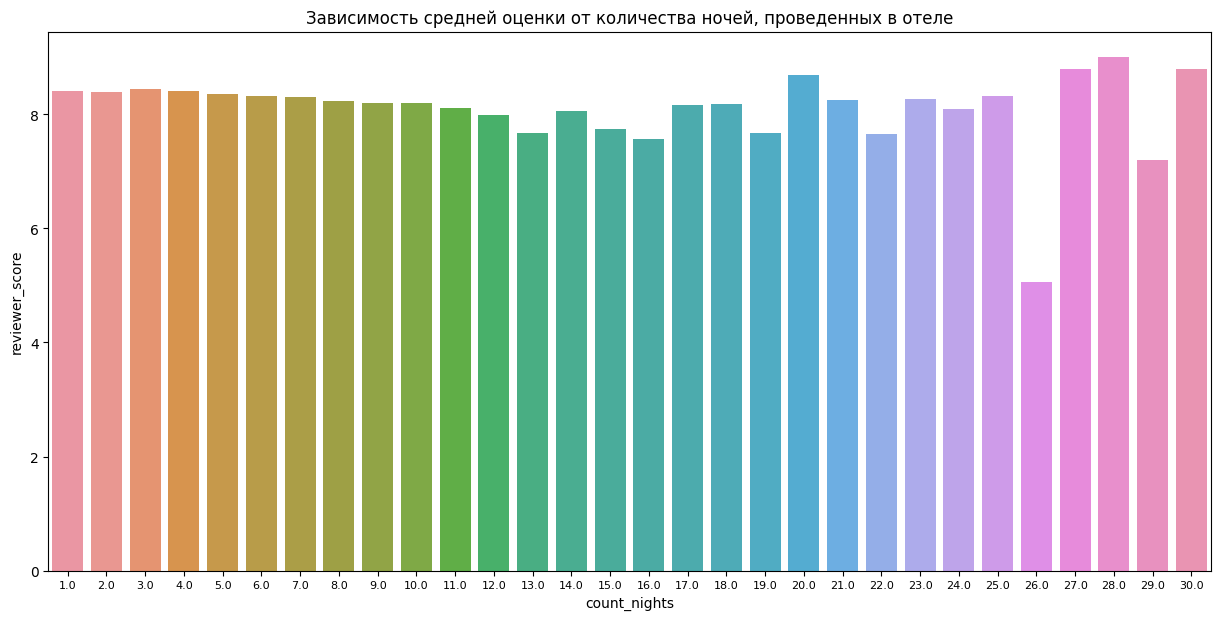

In [49]:
plt.figure(figsize=(15, 7))
sns.barplot(x='count_nights',
            y='reviewer_score',
            ci=None,
            data=data[mask]);

plt.title('Зависимость средней оценки от количества ночей, проведенных в отеле')
plt.ylabel='Оценка'
plt.xlabel='Количество ночей'

plt.xticks(fontsize=8)
plt.yticks(fontsize=10);

При проживании до 10 дней средняя оценка колеблется очень незначительно, далее идет разброс.

Booking.com предлагает указывать 3 вида путешествий: поездка связана с отдыхом, деловая поездка, другое. Добавим флаг вида отдыха: 1 - Leisure trip (поездка, связанная с отдыхом), 0 - остальные виды

In [50]:
data['trip_type'] = data['tags'].str.contains('Leisure').astype(int)
data['trip_type'].sum()

415214

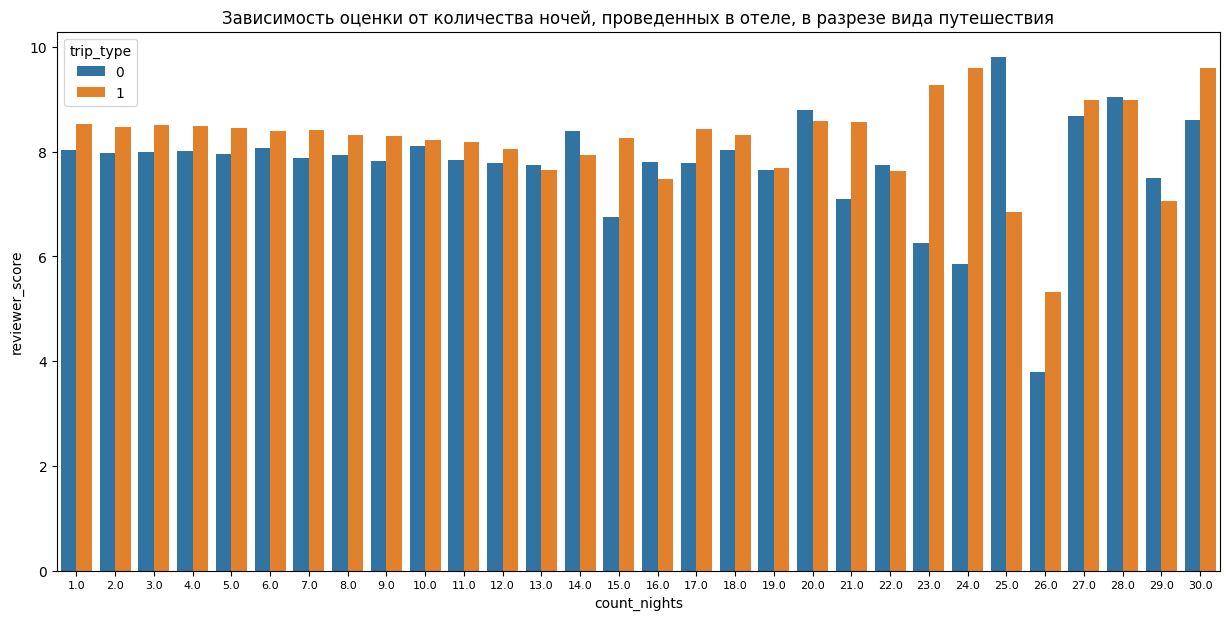

In [51]:
plt.figure(figsize=(15, 7))
sns.barplot(x='count_nights',
            y='reviewer_score',
            hue='trip_type',
            ci=None,
            data=data[mask]);
plt.title('Зависимость оценки от количества ночей, проведенных в отеле, в разрезе вида путешествия')
plt.ylabel='Оценка'
plt.xlabel='Количество ночей'

plt.xticks(fontsize=8)
plt.yticks(fontsize=10);


При проживании до 10 ночей оценки в разрезе вида поездки приблизительно одинаковые и как будто не зависят от длительности путешествия. Далее наблюдается чуть большее разнообразие в обеих категориях, при этом у тех рецензентов, которые отправились отдыхать оценки практически всегда выше. 

добавим флаг наличия животных: 1 - With a pet, 0 - без животных

In [52]:
data['trip_pet'] = data['tags'].str.contains('With a pet').astype(int)
data['trip_pet'].sum()

1395

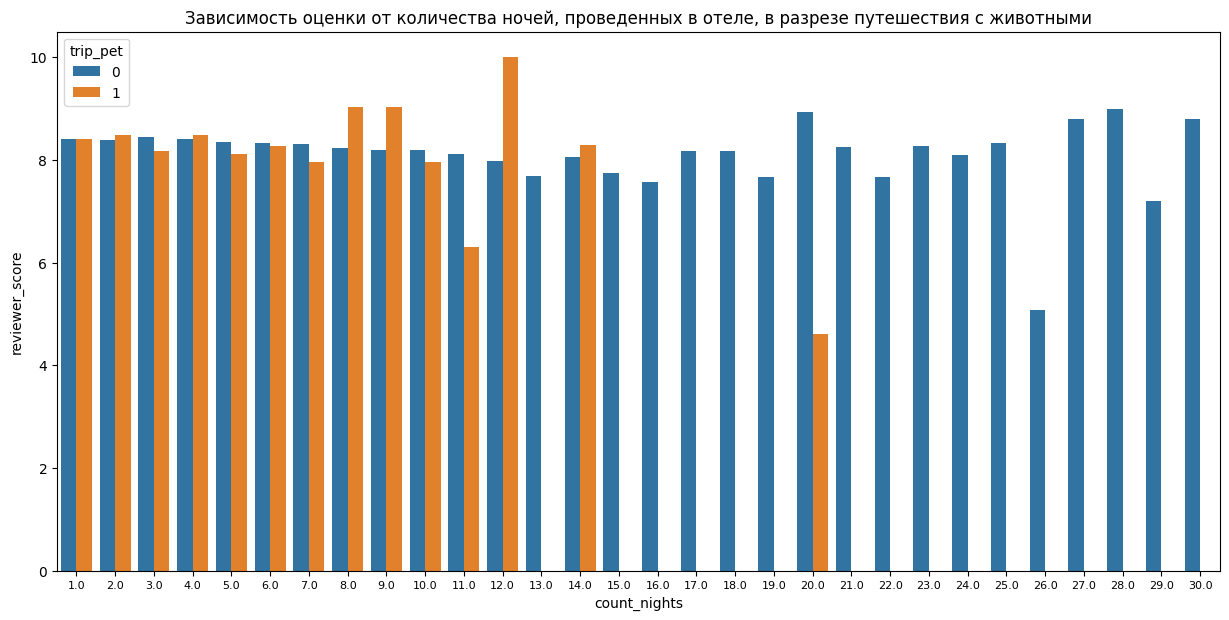

In [53]:
plt.figure(figsize=(15, 7))
sns.barplot(x='count_nights',
            y='reviewer_score',
            hue='trip_pet',
            ci=None,
            data=data[mask]);

plt.title('Зависимость оценки от количества ночей, проведенных в отеле, в разрезе путешествия с животными')
plt.ylabel='Оценка'
plt.xlabel='Количество ночей'

plt.xticks(fontsize=8)
plt.yticks(fontsize=10);


In [54]:
data[(data['count_nights'] == 20) & (data['trip_pet'] == 1)]['reviewer_nationality'].value_counts()

 Qatar     1
Name: reviewer_nationality, dtype: int64

Длительность поездок с животными не более 2-х недель. Исключение составляет значение 20 дней, но это всего одна запись. В поездках с животными средние оценки отличаются от оценок, выставленных в поездках без животных.

создадим новый признак - тип комнат, впоследствии закодируем его

In [55]:
contain_room = tags_data[tags_data.str.contains('room')]

print(f'Количество типов фраз со словом \'room\': {contain_room.nunique()}')
contain_room.unique()[:20]

Количество типов фраз со словом 'room': 124


array(['2 rooms', '3 rooms', 'Double Hilton Guestroom',
       'Kings Three Bedroom Suite', 'Two Bedroom Deluxe Suite',
       'Master Bedroom Double', 'Minsters Deluxe One Bedroom Suite',
       'One Bedroom Suite', 'Double or Twin Room with Bathroom',
       'One Bedroom Apartment', 'Double Room with Private Bathroom',
       'Twin Hilton Guestroom', 'Queen Guestroom',
       'Two Bedroom Apartment', 'King Guestroom',
       'Compact Double Room with Private Bathroom',
       'Superior Double Bedroom', 'Deluxe One Bedroom Apartment',
       'Superior Two Bedroom Apartment', 'Deluxe King Guestroom'],
      dtype=object)

In [56]:
room_list = set(contain_room.tolist())

def get_room_type(tags):

    for room in room_list:
        if room in tags:
            return room
        
        
data['rooms_type'] = data['tags'].apply(get_room_type)      

Признак `review_date`

Создадим новые признаки на основе даты выставления оценки: `review_year` - год, `review_month` - месяц, `review_weekend` - флаг выходного дня: 1 - выходной, 0 - будний день.

In [57]:
data['review_date'] = pd.to_datetime(data['review_date'])

# создадим признаки, связанные с датой
data['review_year'] = data['review_date'].dt.year
data['review_month'] = data['review_date'].dt.month
data['review_weekend'] = data['review_date'].dt.dayofweek.between(5,6).astype(int)

Посмотрим на распределение оценок в зависимости от новых признаков.

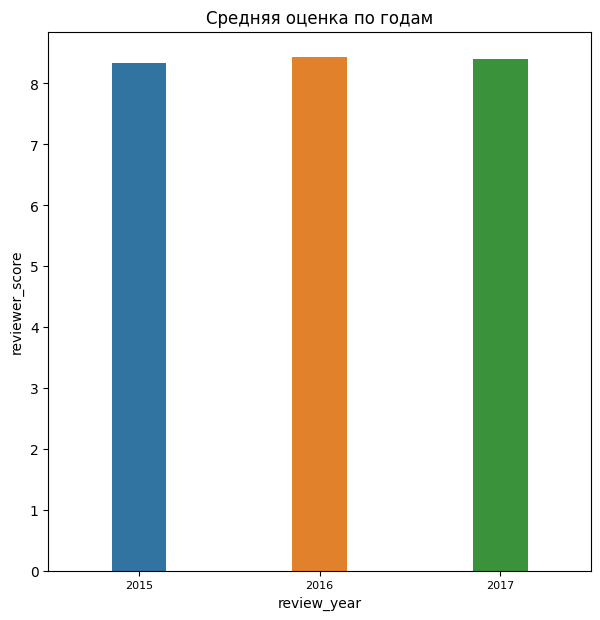

In [58]:
plt.figure(figsize=(7, 7))
sns.barplot(x='review_year',
            y='reviewer_score',
            ci=None,
            width=0.3,
            data=data[mask]);

plt.title('Средняя оценка по годам')


plt.xticks(fontsize=8)
plt.yticks(fontsize=10);

Средние оценки, выставленные в 2017 году незначительно выше предыдущих лет.

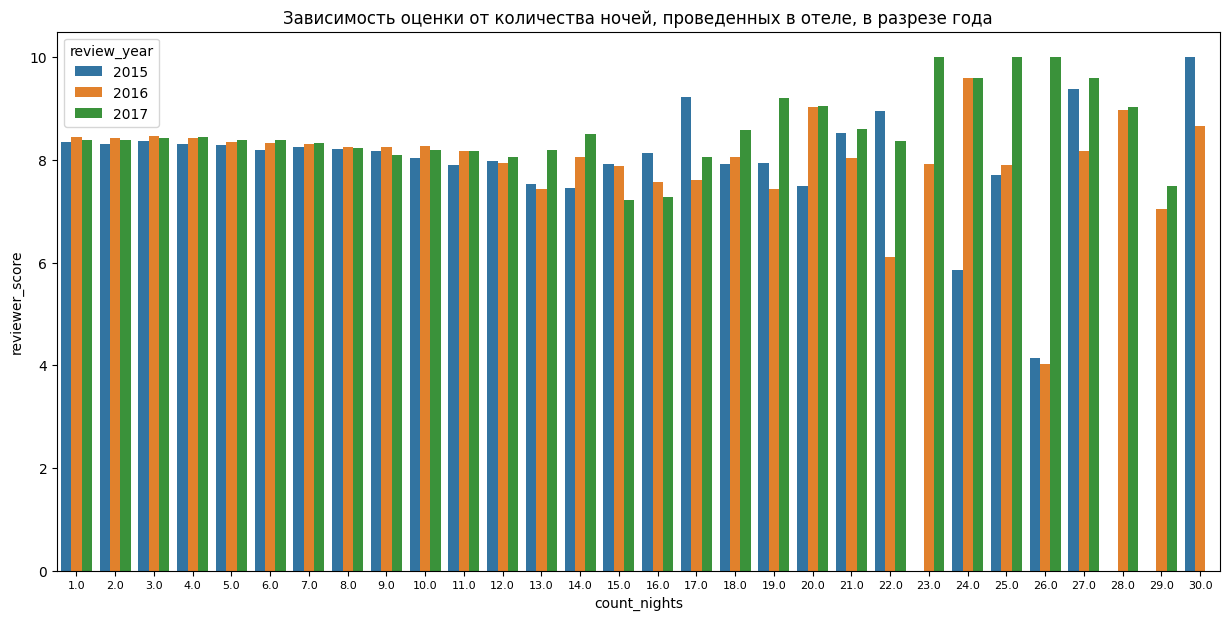

In [59]:
plt.figure(figsize=(15, 7))
sns.barplot(x='count_nights',
            y='reviewer_score',
            hue='review_year',
            ci=None,
            data=data[mask]);

plt.title('Зависимость оценки от количества ночей, проведенных в отеле, в разрезе года')

plt.xticks(fontsize=8)
plt.yticks(fontsize=10);

До 12 дней оценки по годам приблизительно одинаковые, далее они начинают различаться, причем в 2017 году оценки в основном выше.

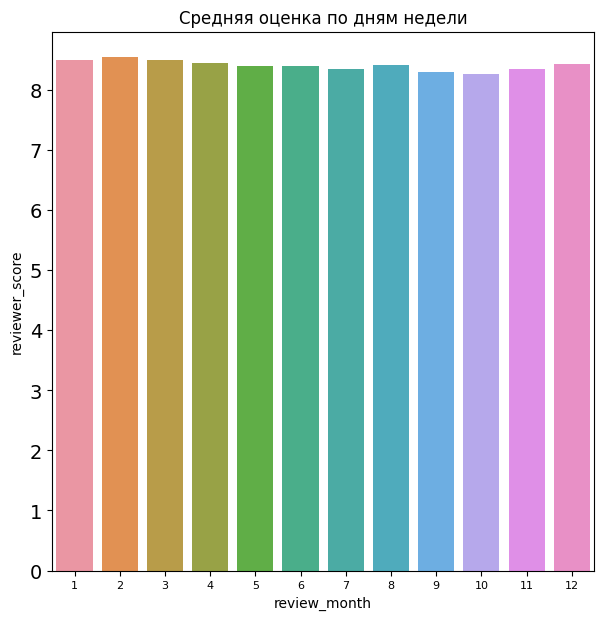

In [60]:
plt.figure(figsize=(7, 7))
sns.barplot(x='review_month',
            y='reviewer_score',
            ci=None,
            data=data[mask]);

plt.title('Средняя оценка по дням недели')
plt.ylabel='Оценка'
plt.xlabel='Количество ночей'

plt.xticks(fontsize=8)
plt.yticks(fontsize=14);

День недели практически не влияет на оценку.

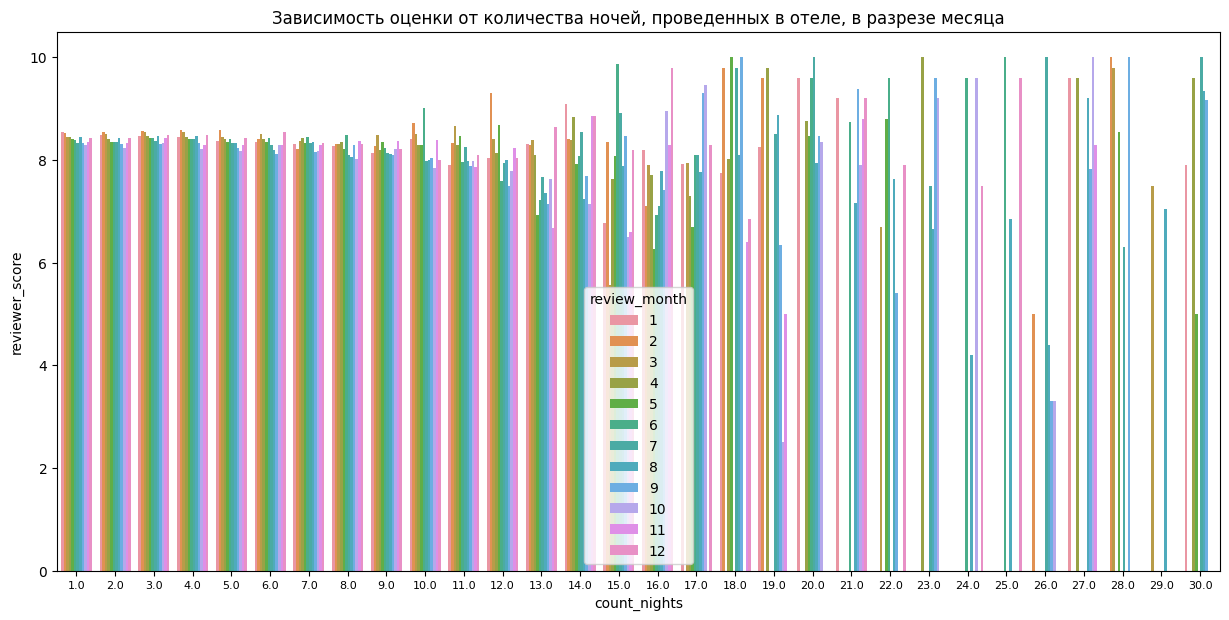

In [61]:
plt.figure(figsize=(15, 7))
sns.barplot(x='count_nights',
            y='reviewer_score',
            hue='review_month',
            ci=None,
            data=data[mask]);

plt.title('Зависимость оценки от количества ночей, проведенных в отеле, в разрезе месяца')

plt.xticks(fontsize=8)
plt.yticks(fontsize=10);

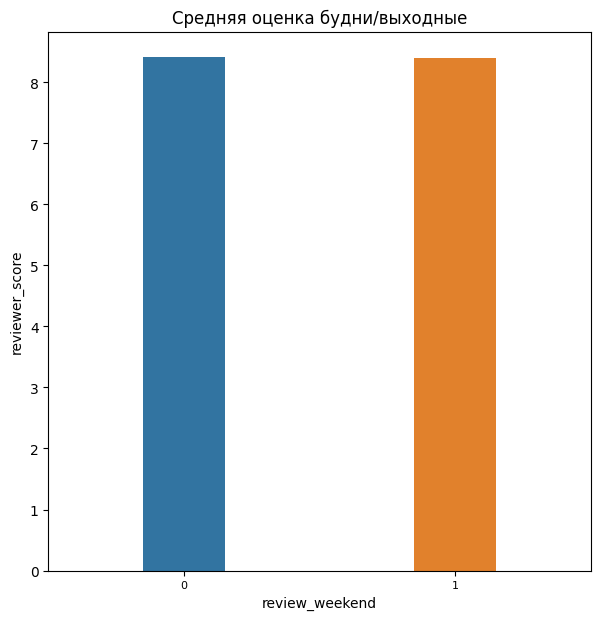

In [62]:
plt.figure(figsize=(7, 7))
sns.barplot(x='review_weekend',
            y='reviewer_score',
            ci=None,
            width=0.3,
            data=data[mask]);

plt.title('Средняя оценка будни/выходные')

plt.xticks(fontsize=8)
plt.yticks(fontsize=10);

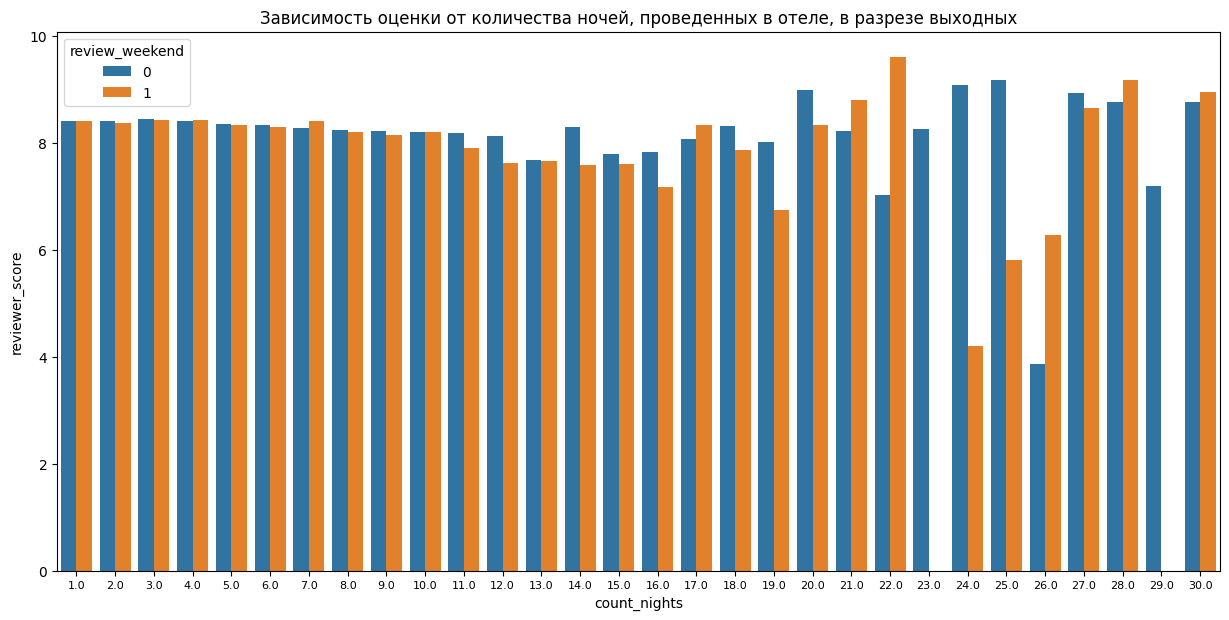

In [63]:
plt.figure(figsize=(15, 7))
sns.barplot(x='count_nights',
            y='reviewer_score',
            ci=None,
            hue='review_weekend',
            data=data[mask]);

plt.title('Зависимость оценки от количества ночей, проведенных в отеле, в разрезе выходных')

plt.xticks(fontsize=8)
plt.yticks(fontsize=10); 

В целом не заметно особого влияния времени выставления оценки. До 10-12 дня на оценку не влияют признаки, связанные с датой, далее разброс во всех случаях увеличивается, но без какой-то внятной тенденции.

Признак `average_score` - средняя оценка за последний год

Введем категории отелей по шкале:

In [64]:
normal = 7.0
good = 8.0
best = 9.0

def get_score_rating(average_score):
    if average_score < normal:
        return 0
    if normal <= average_score < good:
        return 1
    if good <= average_score < best:
        return 2
    if average_score >= best:
        return 3
    
    
data['hotel_rating'] = data['average_score'].apply(get_score_rating)
data['hotel_rating'].value_counts()


2    339503
1     88110
3     79152
0      5607
Name: hotel_rating, dtype: int64

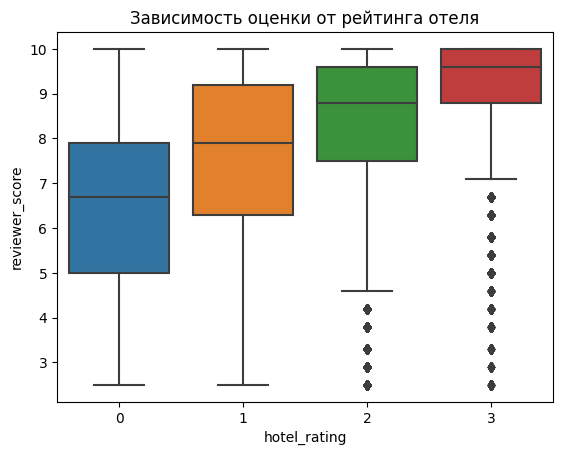

In [65]:
sns.boxplot(x='hotel_rating', 
            y='reviewer_score', 
            data=data[mask])

plt.title('Зависимость оценки от рейтинга отеля');

Как и ожидалось, оценка, данная рецензентом сильно зависит от рейтинга отеля.

Признак `reviewer_nationality`

In [66]:
reviewer_nationality = data['reviewer_nationality'].unique().tolist()
print(f'\nВ датасете представлено {len(reviewer_nationality)} стран, из которых происходят рецензенты\n')
data.reviewer_nationality.value_counts()


В датасете представлено 227 стран, из которых происходят рецензенты



 United Kingdom               243723
 United States of America      35209
 Australia                     21559
 Ireland                       14733
 United Arab Emirates          10177
                               ...  
 Vatican City                      1
 Guinea                            1
 Comoros                           1
 Anguilla                          1
 Palau                             1
Name: reviewer_nationality, Length: 227, dtype: int64

In [67]:
# создадим признак равенства страны отеля и страны рецензента
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip())
data['eq_country'] = (data['reviewer_nationality'] == data['country']).astype(int)

data['eq_country'].value_counts()

0    335091
1    177281
Name: eq_country, dtype: int64

In [68]:
# подгрузим датасет с названиями регионов/суб-регионов по странам. Нам понадобится субрегион
data_country = pd.read_csv(DATA_DIR+'/continents2.zip') 
data_country.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      249 non-null    object 
 1   alpha-2                   248 non-null    object 
 2   alpha-3                   249 non-null    object 
 3   country-code              249 non-null    int64  
 4   iso_3166-2                249 non-null    object 
 5   region                    248 non-null    object 
 6   sub-region                248 non-null    object 
 7   intermediate-region       107 non-null    object 
 8   region-code               248 non-null    float64
 9   sub-region-code           248 non-null    float64
 10  intermediate-region-code  107 non-null    float64
dtypes: float64(3), int64(1), object(7)
memory usage: 21.5+ KB


In [69]:
data_country[:2]

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN


В процессе работы над объединением таблиц выяснилось, что часть стран некоректно заполнена рецензентами. Заменим на корректные названия согласно ISO 3166-2

In [70]:
# словарь для замены
correct_country = {'United States of America':'United States', 'Crimea':'Ukraine', 
                   'Brunei':'Brunei Darussalam', 'Kosovo':'Serbia', 'Bosnia and Herzegovina':'Bosnia And Herzegovina',
                   'Macau': 'Macao', 'Abkhazia Georgia': 'Georgia', 'Cura ao':'Curaçao',
                   'Ivory Coast': 'Côte D\'Ivoire', 'U S Virgin Islands':'Virgin Islands (U.S.)', 'Saint Martin': 'Saint Martin (French part)',
                   'Palestinian Territory': 'Palestine, State of', 'British Virgin Islands': 'Virgin Islands (British)',
                   'Democratic Republic of the Congo': 'Congo (Democratic Republic Of The)', 'St Maarten': 'Sint Maarten (Dutch part)',
                   'Saint Barts': 'Saint Barthélemy', 'Swaziland': 'Eswatini', 'Bonaire St Eustatius and Saba': 'Bonaire, Sint Eustatius and Saba',
                   'Turks Caicos Islands': 'Turks and Caicos Islands', 'Vatican City': 'Holy See', 'Antigua Barbuda': 'Antigua and Barbuda',
                   'Saint Vincent Grenadines': 'Saint Vincent and the Grenadines', 'Cape Verde': 'Cabo Verde', 'Reunion': 'Réunion',
                   'Falkland Islands Malvinas': 'Falkland Islands (Malvinas)', 'St Pierre and Miquelon': 'Saint Pierre and Miquelon',
                   'Cocos K I': 'Cocos (Keeling) Islands', 'East Timor': 'Timor-Leste', 'Svalbard Jan Mayen': 'Svalbard and Jan Mayen',
                   'Central Africa Republic': 'Central African Republic'
                   } 
# заменим значения
data['reviewer_nationality'].replace(correct_country, inplace=True)
data['reviewer_nationality'].nunique()


224

In [71]:
data = pd.merge(
    data, 
    data_country[['name','sub-region']], 
    left_on='reviewer_nationality', 
    right_on='name', 
    how='left'
)
# удалим лишний столбец
data.drop('name', axis=1, inplace=True)

In [72]:
data[:2]

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,count_nights,trip_type,trip_pet,rooms_type,review_year,review_month,review_weekend,hotel_rating,eq_country,sub-region
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,2.0,1,0,None,2017,7,0,2,0,Northern Europe
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,2016-12-12,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,1.0,1,0,None,2016,12,0,2,0,Western Europe


В данных присутствует национальность - Антарктида. Таких записей 3. Для Антарктиды не существует региона в таблице,
поэтому я просто их присоеденю к наиболее часто встречающемуся региону. Этим же значением заполню субрегион для 526 записи с незаполненной национальностью. 

In [73]:
data[data['reviewer_nationality'] == 'Antarctica']

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,count_nights,trip_type,trip_pet,rooms_type,review_year,review_month,review_weekend,hotel_rating,eq_country,sub-region
144897,108 Baker Street Westminster Borough London W1...,341,2016-01-14,8.2,Park Plaza Sherlock Holmes London,Antarctica,Some of bathroom fittings were a bit loose bu...,15,1496,The location was very convenient Baker St Sta...,...,1.0,0,0,None,2016,1,0,2,0,None
144911,Mommsengasse 5 04 Wieden 1040 Vienna Austria,68,2016-09-06,8.6,Pakat Suites Hotel,Antarctica,No Negative,0,664,It s not right in the middle of the city but ...,...,2.0,1,0,None,2016,9,0,2,0,None
208534,Wiedner G rtel 14 04 Wieden 1040 Vienna Austria,226,2016-09-27,8.3,Hotel Prinz Eugen,Antarctica,No Negative,0,3308,Repeat visitor Excellent location close to th...,...,2.0,1,0,None,2016,9,0,2,0,None


In [74]:
data['sub-region'].mode()

0    Northern Europe
Name: sub-region, dtype: object

In [75]:
# заполним пустые значения
data['sub-region'].fillna('Northern Europe', inplace=True)
data['sub-region'].isnull().sum()

0

In [76]:
data['sub-region'].value_counts()

Northern Europe                    273137
Western Asia                        47127
Northern America                    43146
Western Europe                      42458
Australia and New Zealand           24776
Southern Europe                     22417
Eastern Europe                      19324
Eastern Asia                         9798
South-eastern Asia                   9782
Sub-Saharan Africa                   6014
Southern Asia                        5897
Latin America and the Caribbean      5114
Northern Africa                      2891
Central Asia                          342
Micronesia                             91
Melanesia                              44
Polynesia                              14
Name: sub-region, dtype: int64

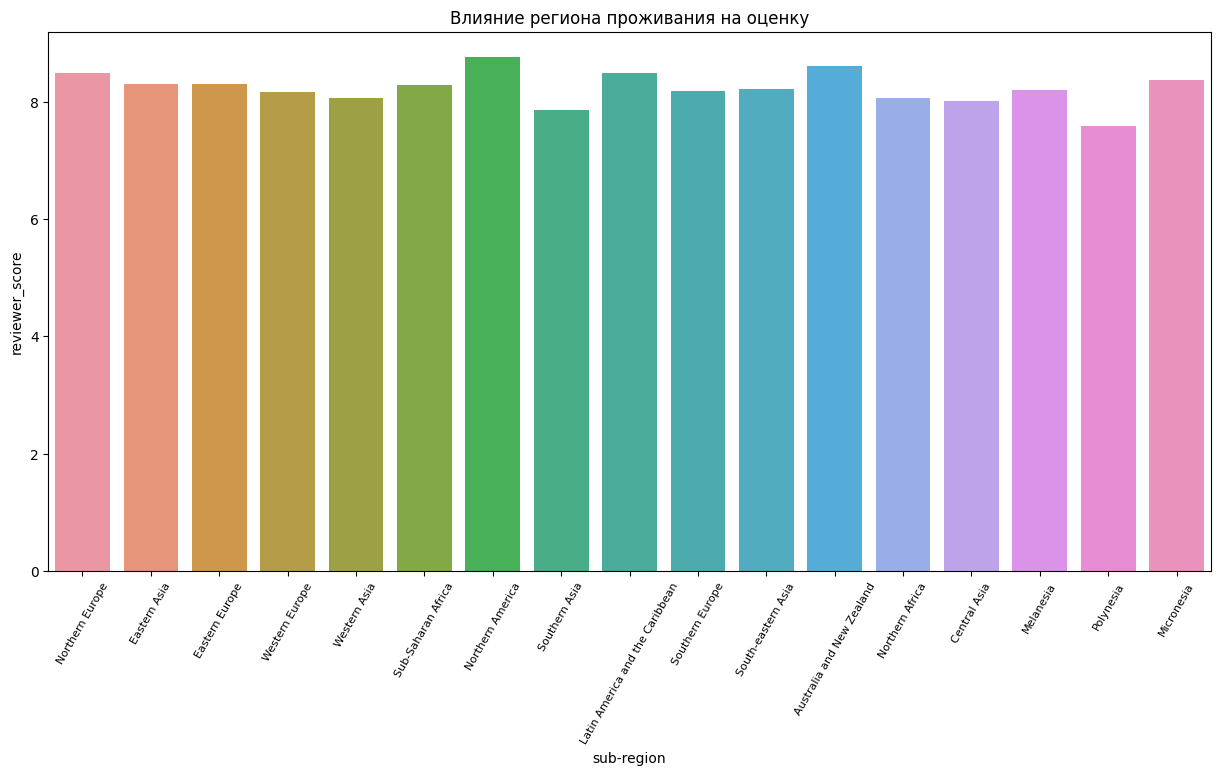

In [77]:
plt.figure(figsize=(15, 7))
sns.barplot(x='sub-region',
            y='reviewer_score',
            ci=None,
            data=data[mask]);

plt.title('Влияние региона проживания на оценку')

plt.xticks(fontsize=8)
plt.yticks(fontsize=10)
plt.xticks(rotation=60);

Заметно некоторое влияние оценки от региона проживания рецензентов.

Признак `days_since_review`

In [78]:
# оставим только число дней и преобразуем к типу int
data['days_since_review'] = (data['days_since_review'].apply(lambda x: x.split()[0])).astype(int)
data['days_since_review'][:5]

0     13
1    234
2    616
3    656
4    444
Name: days_since_review, dtype: int32

Признаки `review_total_negative_word_counts`, `negative_review`, `review_total_positive_word_counts`, `positive_review`

In [79]:
# избавимся от лишних пробелов
data['negative_review'] = data['negative_review'].str.strip().str.lower()
data['positive_review'] = data['positive_review'].str.strip().str.lower()


In [80]:
print(f'\nТОП-50 негативных отзывов')
data['negative_review'].value_counts()[:50]


ТОП-50 негативных отзывов


no negative                       127314
nothing                            21116
n a                                 1811
none                                1497
                                     845
nothing really                       653
small room                           558
breakfast                            541
all good                             538
no complaints                        520
location                             496
nothing at all                       466
everything                           416
nothing to dislike                   373
price                                344
nil                                  332
small rooms                          306
everything was perfect               276
na                                   271
can t think of anything              250
leaving                              244
absolutely nothing                   242
everything was great                 221
expensive                            206
nothing to compl

In [81]:
print(f'\nТОП-50 позитивных отзывов')
data['positive_review'].value_counts()[:50]


ТОП-50 позитивных отзывов


no positive                        35499
location                           11835
everything                          3301
nothing                             1711
great location                      1678
the location                        1590
good location                       1478
breakfast                            786
friendly staff                       724
excellent location                   634
staff                                546
location and staff                   452
location staff                       431
location location location           345
location was great                   327
good breakfast                       316
everything was perfect               316
location was good                    309
comfy bed                            301
perfect location                     285
the staff                            280
location is great                    278
location is good                     254
all                                  250
clean           

Можно выделить несколько слов (словосочетаний), указывающих на отсутствие негатива / позитива и выделить их в бинарные признаки. Так же можно создать признаки-флаги на основе некоторых часто встречающихся слов, указывающих на то, что именно понравилось/непонравилось рецензенту.

In [82]:
non_negat_lst = ['no negative', 'no negative', '', 'n a', 'none', 'all good', 'no complaints',
                 'nothing at all', 'nothing to dislike', 'nil', 'everything was perfect', 'na',
                 'can t think of anything', 'absolutely nothing', 'everything was great',  
                 'nothing to complain about', 'no', 'nothing not to like', 'having to leave',
                 'everything was good', 'liked everything', 'was perfect', 'non', 'nothing in particular',
                 'everything was fine', 'all was good', 'nothing everything was great',
                 'nothing everything was perfect', 'nothing it was perfect']

non_posit_lst = ['no positive', 'nothing']

def get_real_pos(negative_review):
    return (negative_review in non_negat_lst)


def get_real_neg(positive_review):
    return (positive_review in non_posit_lst)

data['real_pos'] = data['negative_review'].apply(get_real_pos).astype(int)
data['real_neg'] = data['positive_review'].apply(get_real_neg).astype(int)

print(data['real_pos'].value_counts(), data['real_neg'].value_counts(), sep='\n')
        

0    375473
1    136899
Name: real_pos, dtype: int64
0    475162
1     37210
Name: real_neg, dtype: int64


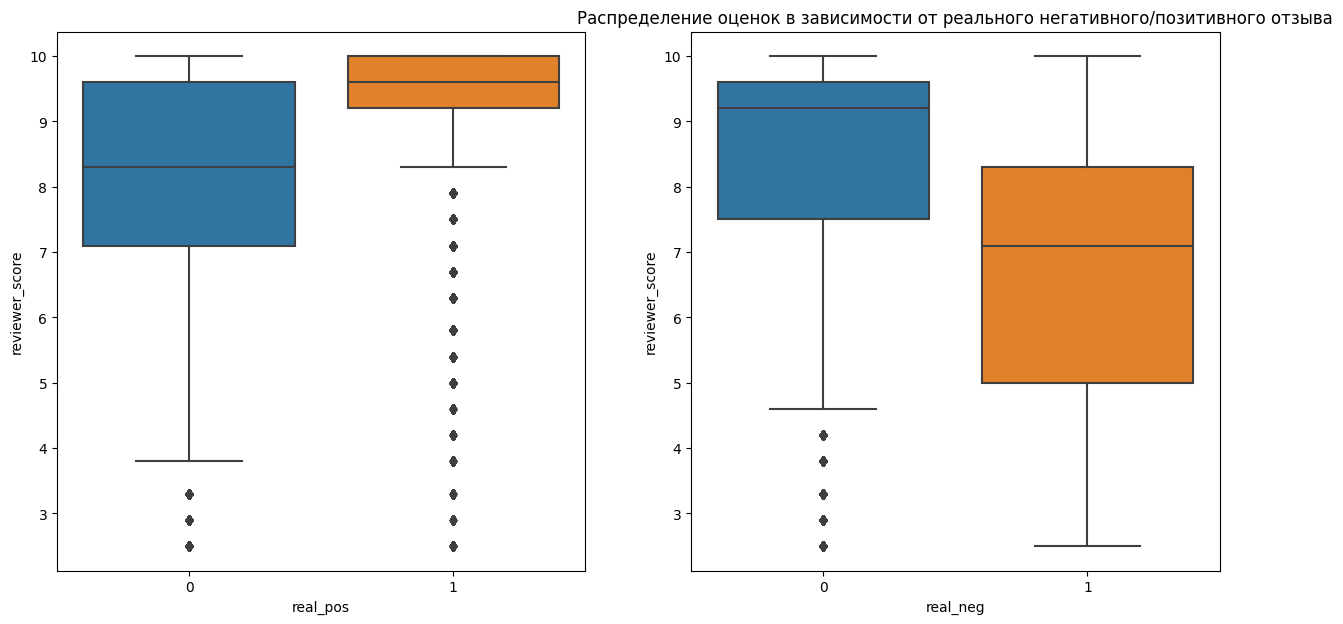

In [83]:
fig, (neg, pos) = plt.subplots(1, 2, figsize=(15, 7))

sns.boxplot(x='real_pos', 
            y='reviewer_score', 
            data=data[mask],
            ax=neg)

sns.boxplot(x='real_neg', 
            y='reviewer_score', 
            data=data[mask],
            ax=pos)

plt.title('Распределение оценок в зависимости от реального негативного/позитивного отзыва');

Как и следовало ожидать, real_pos в `negative_review` дает существенно более высокие оценки, чем настоящие негативные отзывы. Аналогично в `positive_review` - real_neg дает более низкие оценки, чем настоящие позитивные отзывы.

In [84]:
neg_lst = ['location', 'breakfast', 'room', 'expensive', 'everything', 'staff']
pos_lst = ['location', 'breakfast', 'room', 'everything', 'staff']

def get_neg_features(negative_review):
    for i in neg_lst:
        if i in negative_review:
            return i
        
        
def get_pos_features(positive_review):
    for i in pos_lst:
        if i in positive_review:
            return i
        
data['neg_features'] = data['negative_review'].apply(get_neg_features)
data['pos_features'] = data['positive_review'].apply(get_pos_features)   

In [85]:
data['neg_features'].value_counts()

room          135504
breakfast      48513
staff          13604
location       10861
expensive       5725
everything      5649
Name: neg_features, dtype: int64

In [86]:
data['pos_features'].value_counts()

location      188423
room           80682
staff          54968
breakfast      52115
everything     12197
Name: pos_features, dtype: int64

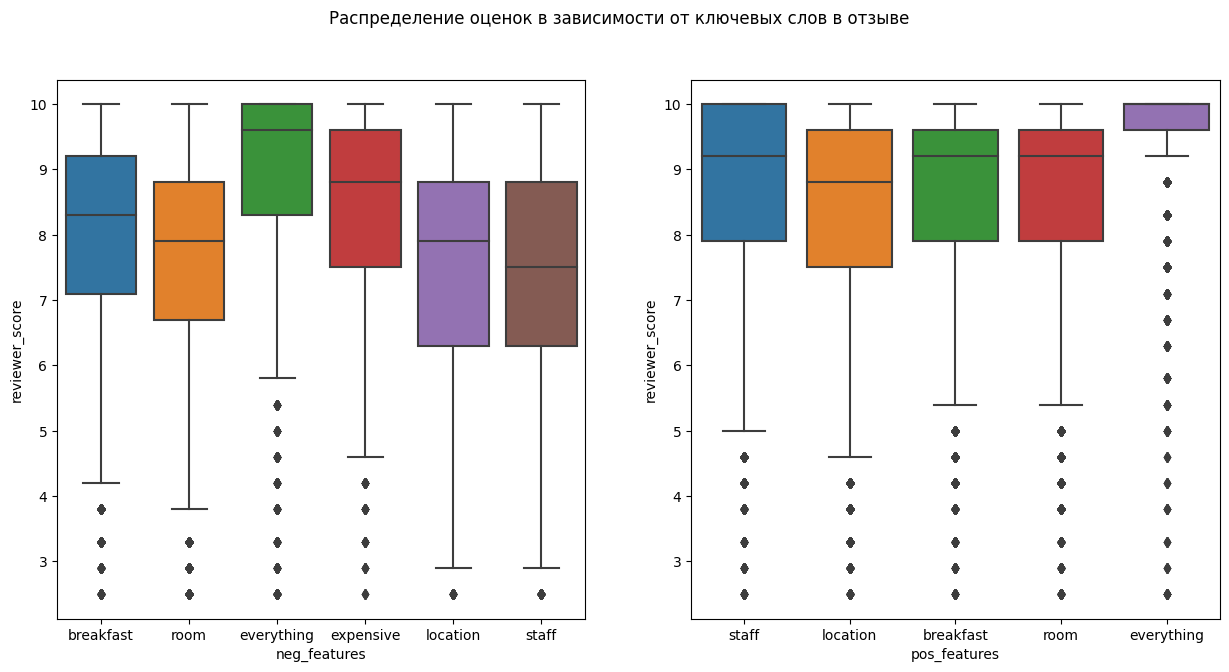

In [87]:
fig, (neg, pos) = plt.subplots(1, 2, figsize=(15, 7))

sns.boxplot(x='neg_features', 
            y='reviewer_score', 
            data=data[mask],
            ax=neg)

sns.boxplot(x='pos_features', 
            y='reviewer_score', 
            data=data[mask],
            ax=pos)

plt.suptitle('Распределение оценок в зависимости от ключевых слов в отзыве');


При подробном изучении получиышихся признаков, я пришла к выводу, что данный метод не корректен, так как сам отзыв может быть, например, негативным, но в нем упоминается искомое слово в позитивном ключе. Пока оставлю эти новые признаки, далее закодирую их и посмотрю, насколько они нужны.

Признак `total_number_of_reviews_reviewer_has_given`

In [88]:
data['total_number_of_reviews_reviewer_has_given'].value_counts()

1      153585
2       66605
3       46537
4       34795
5       27451
        ...  
155         1
170         1
161         1
135         1
355         1
Name: total_number_of_reviews_reviewer_has_given, Length: 198, dtype: int64

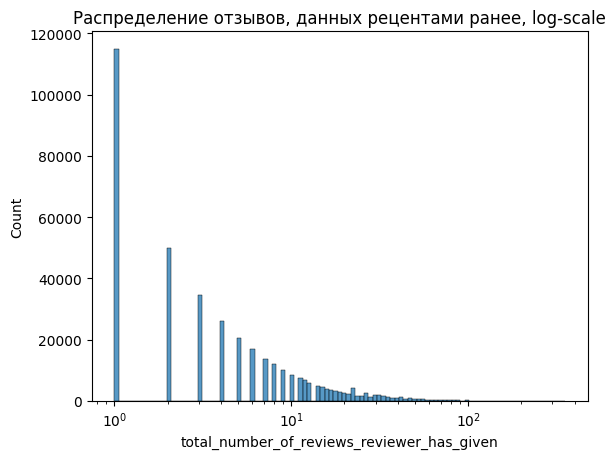

In [89]:
sns.histplot(x='total_number_of_reviews_reviewer_has_given',
            log_scale=True, 
            data=data[mask])
plt.title('Распределение отзывов, данных рецентами ранее, log-scale');

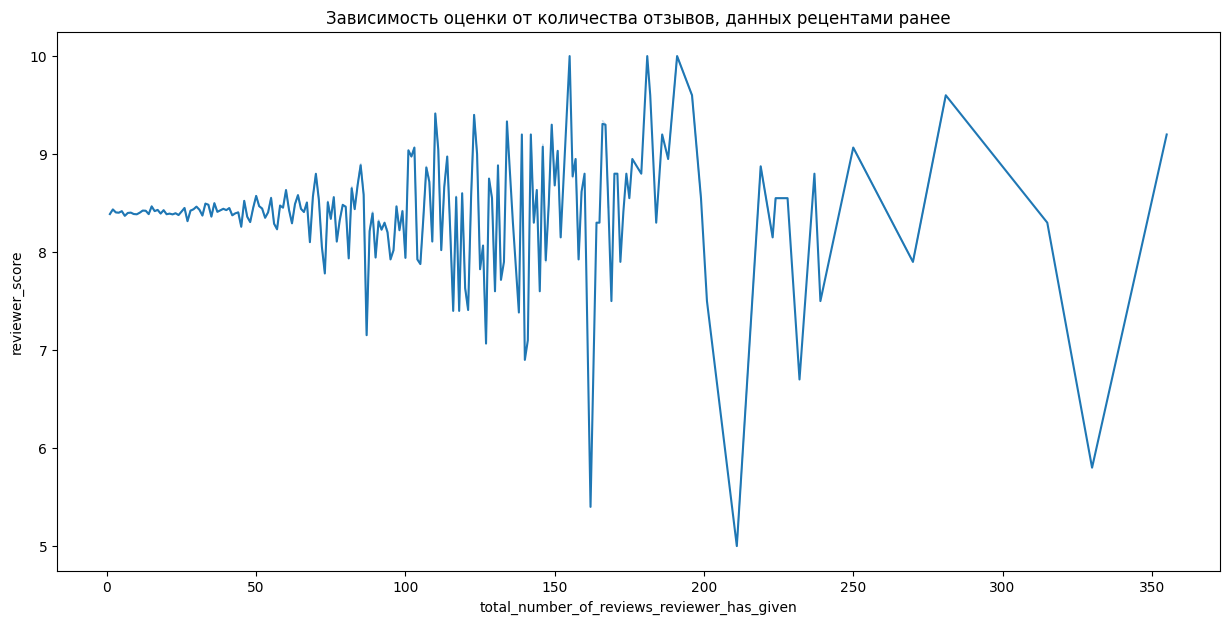

In [90]:
plt.figure(figsize=(15, 7))
sns.lineplot(x='total_number_of_reviews_reviewer_has_given',
             y='reviewer_score',
             ci=False, 
             data=data[mask])

plt.title('Зависимость оценки от количества отзывов, данных рецентами ранее');

Попробуем разбить признак на равномерные категории

In [91]:
data['number_of_reviewer_has_given_bins'] = pd.cut(data['total_number_of_reviews_reviewer_has_given'],
                                                   bins=np.linspace(0, data['total_number_of_reviews_reviewer_has_given'].max() +1, 7),
                                                   labels=[1,2,3,4,5,6]
                                                   )
data['number_of_reviewer_has_given_bins'].value_counts()

1    508757
2      3238
3       328
4        34
5         8
6         7
Name: number_of_reviewer_has_given_bins, dtype: int64

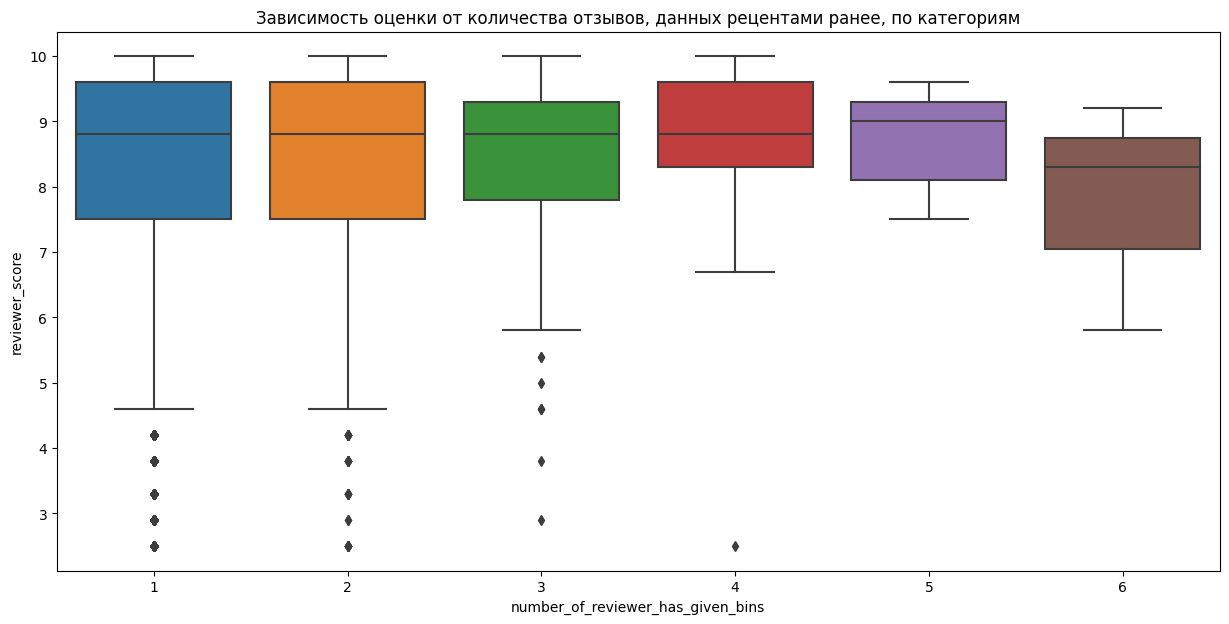

In [92]:
plt.figure(figsize=(15, 7))
sns.boxplot(x='number_of_reviewer_has_given_bins',
             y='reviewer_score',
             data=data[mask]);

plt.title('Зависимость оценки от количества отзывов, данных рецентами ранее, по категориям');

на оценку может влиять только последняя категория - количество ранее оставленных отзывов более 296

In [93]:
data['number_of_reviewer_has_given_bins'] = data['number_of_reviewer_has_given_bins'].astype(int)

### Преобразование признаков

Кодируем признаки

In [94]:
data = pd.get_dummies(data, columns=['country', 'sub-region', 'neg_features', 'pos_features'])

In [95]:
bin_encoder = ce.BinaryEncoder(cols=['rooms_type'])
type_bin = bin_encoder.fit_transform(data['rooms_type'])
data = pd.concat([data, type_bin], axis=1)

In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 512372 entries, 0 to 512371
Data columns (total 79 columns):
 #   Column                                          Non-Null Count   Dtype         
---  ------                                          --------------   -----         
 0   hotel_address                                   512372 non-null  object        
 1   additional_number_of_scoring                    512372 non-null  int64         
 2   review_date                                     512372 non-null  datetime64[ns]
 3   average_score                                   512372 non-null  float64       
 4   hotel_name                                      512372 non-null  object        
 5   reviewer_nationality                            512372 non-null  object        
 6   negative_review                                 512372 non-null  object        
 7   review_total_negative_word_counts               512372 non-null  int64         
 8   total_number_of_reviews           

Удалим ненужные признаки

In [97]:
drop_cols = ['hotel_address', 'hotel_name', 'reviewer_nationality', 
             'negative_review', 'positive_review', 'tags',
             'postcode', 'city', 'rooms_type', 'review_date']
data = data.drop(drop_cols, axis=1)

data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 512372 entries, 0 to 512371
Data columns (total 69 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   additional_number_of_scoring                    512372 non-null  int64  
 1   average_score                                   512372 non-null  float64
 2   review_total_negative_word_counts               512372 non-null  int64  
 3   total_number_of_reviews                         512372 non-null  int64  
 4   review_total_positive_word_counts               512372 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given      512372 non-null  int64  
 6   days_since_review                               512372 non-null  int32  
 7   lat                                             512372 non-null  float64
 8   lng                                             512372 non-null  float64
 9   sample                    

In [98]:
# Проверим отсутствие пропусков
for column in data.columns:
    if data[column].isna().sum() > 0:
        print(column)
    

count_nights


In [99]:
data['count_nights'].value_counts(dropna=False)

1.0     192369
2.0     133069
3.0      95246
4.0      47493
5.0      20698
6.0       9723
7.0       7339
8.0       2477
9.0       1284
10.0       879
11.0       413
12.0       312
14.0       245
13.0       243
NaN        191
15.0       114
16.0        57
17.0        42
18.0        33
19.0        28
21.0        23
20.0        19
27.0        11
30.0        11
23.0        10
22.0        10
25.0         7
26.0         7
28.0         7
24.0         6
29.0         5
31.0         1
Name: count_nights, dtype: int64

In [100]:
# заполним пропуски медианным значением
data['count_nights'] = data['count_nights'].fillna(1)

Для проверки на нормальность используем тест Д`Агостино, так как размер выборки существенно больше 1000

In [101]:
normal_check_cols = ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews',
               'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'days_since_review',
               'lat', 'lng', 'log_additional_number_of_scoring', 'log_average_score', 'log_review_total_negative_word_counts',
               'log_total_number_of_reviews', 'log_review_total_positive_word_counts', 
               'log_total_number_of_reviews_reviewer_has_given', 'count_nights']

# уровень значимости
alpha = 0.05

for elem in normal_check_cols:
    stat, p = normaltest(data[elem])
    
    print(Style.BRIGHT + elem + Style.RESET_ALL)
    print(f'p = {p:e}, stat = {stat}')
    
    
    if p < alpha:
        print('Данные распределены не нормально, отвергаем H0')
    else:
        print('Данные распределены нормально, принимаем H0')

additional_number_of_scoring
p = 0.000000e+00, stat = 230807.55808820456
Данные распределены не нормально, отвергаем H0
average_score
p = 0.000000e+00, stat = 24903.62996961417
Данные распределены не нормально, отвергаем H0
review_total_negative_word_counts
p = 0.000000e+00, stat = 471761.35970643046
Данные распределены не нормально, отвергаем H0
total_number_of_reviews
p = 0.000000e+00, stat = 225678.78802495118
Данные распределены не нормально, отвергаем H0
review_total_positive_word_counts
p = 0.000000e+00, stat = 460564.2716038388
Данные распределены не нормально, отвергаем H0
total_number_of_reviews_reviewer_has_given
p = 0.000000e+00, stat = 532642.0962519115
Данные распределены не нормально, отвергаем H0
days_since_review
p = 0.000000e+00, stat = 261021.02324721985
Данные распределены не нормально, отвергаем H0
lat
p = 0.000000e+00, stat = 102691.75982161437
Данные распределены не нормально, отвергаем H0
lng
p = 0.000000e+00, stat = 168327.61800747117
Данные распределены не норм

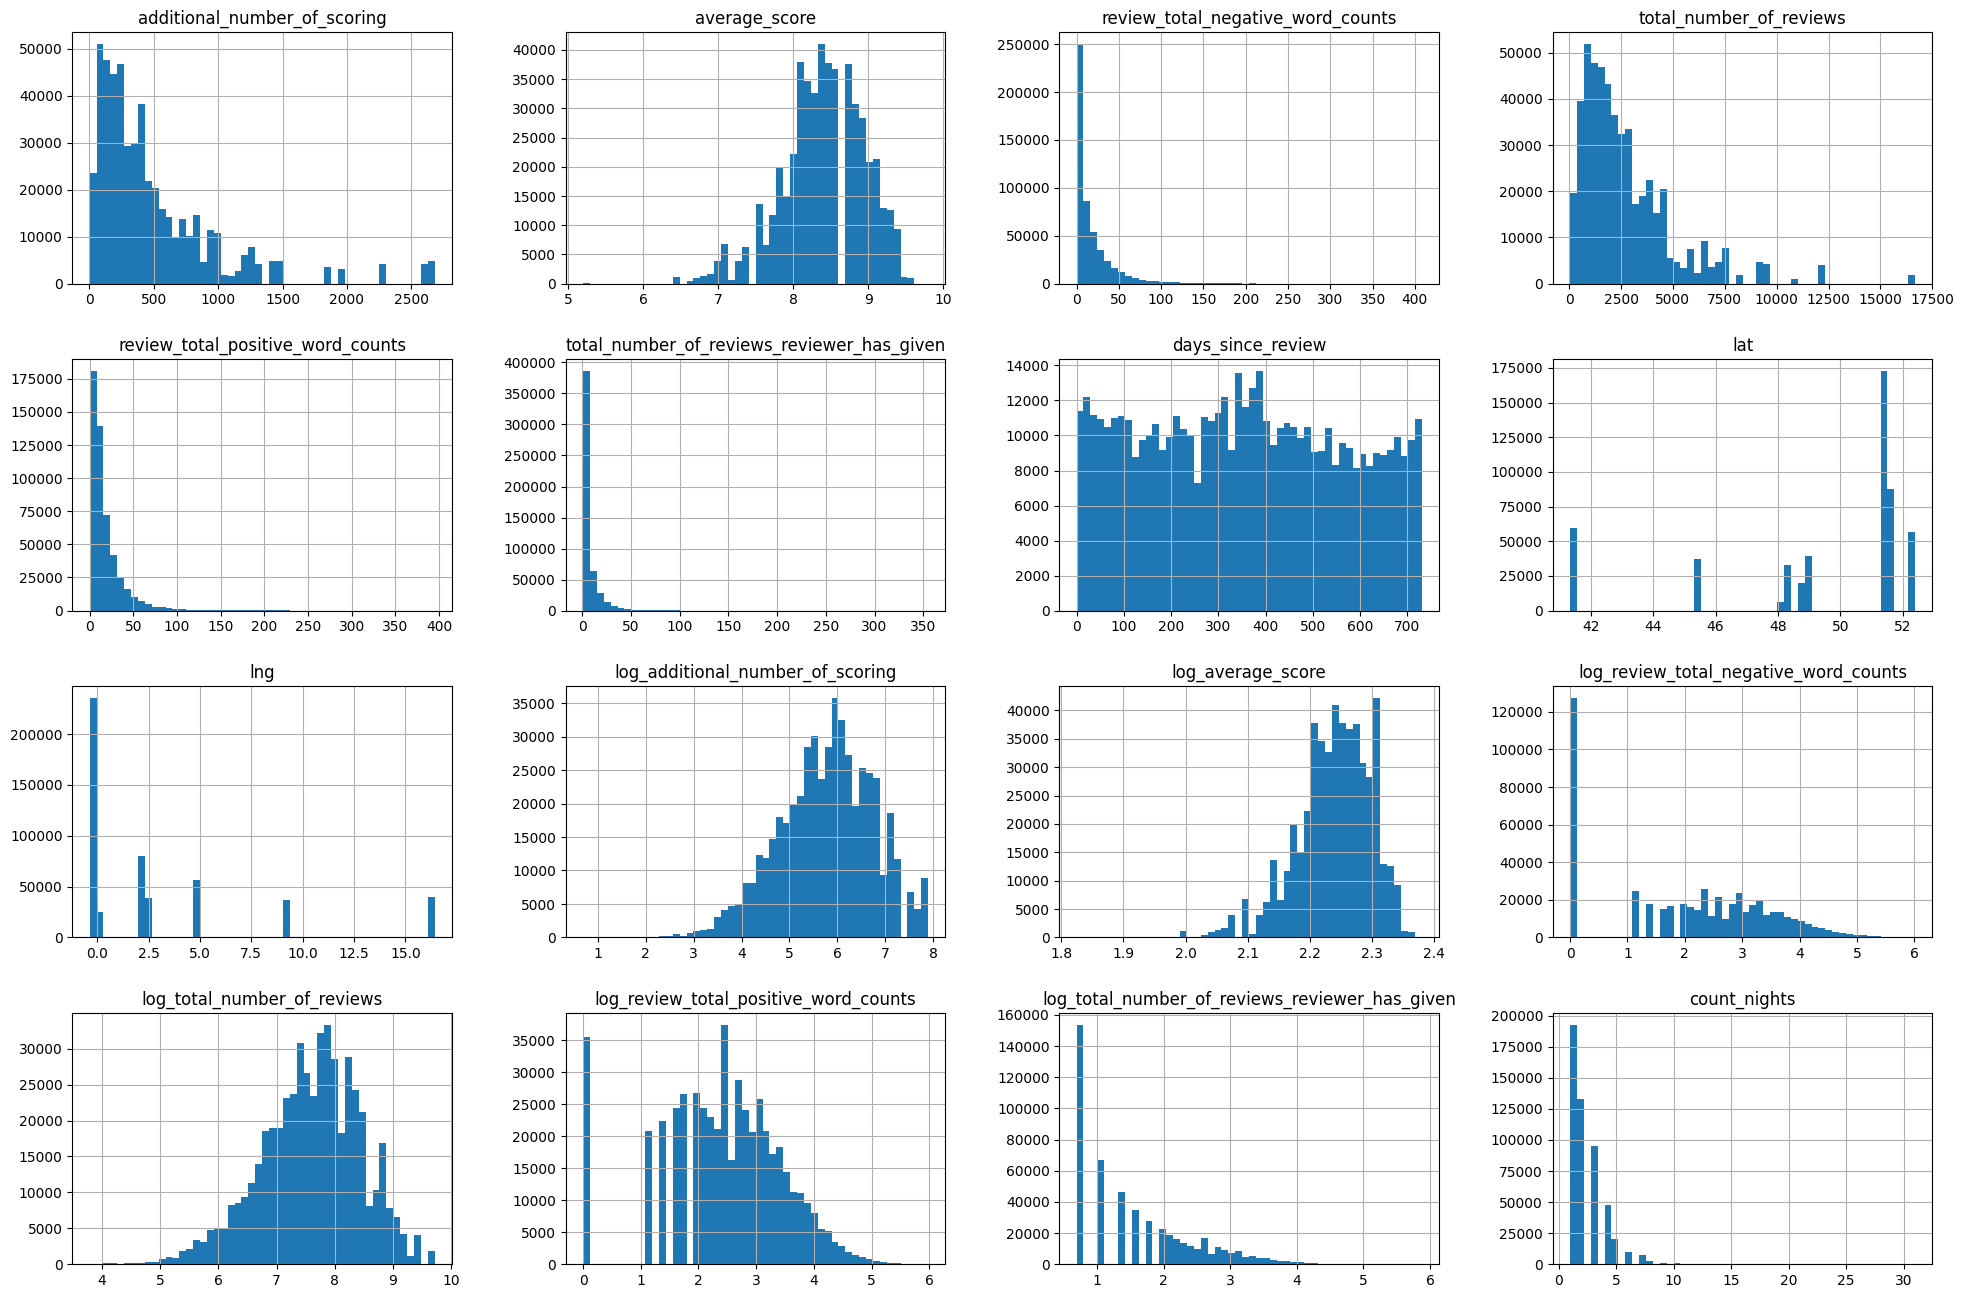

In [102]:
data[normal_check_cols].hist(figsize=(24,16), bins=50);

Нормализация. Использую метод RibustScaller, так как в данных есть выбросы.  

Эксперимент показал, что нормализация ухудшает метрику, использовать не буду.

In [103]:
# инициализируем нормализатор 
#rb_scaler = preprocessing.RobustScaler()
# кодируем исходный датасет
#data[normal_check_cols] = rb_scaler.fit_transform(data[normal_check_cols])


### Отбор признаков

Посмотрим на корреляцию по методу Спирмена (так как данные не распределены нормально),выводить будем признаки с корреляцией больше 0.7 по модулю.

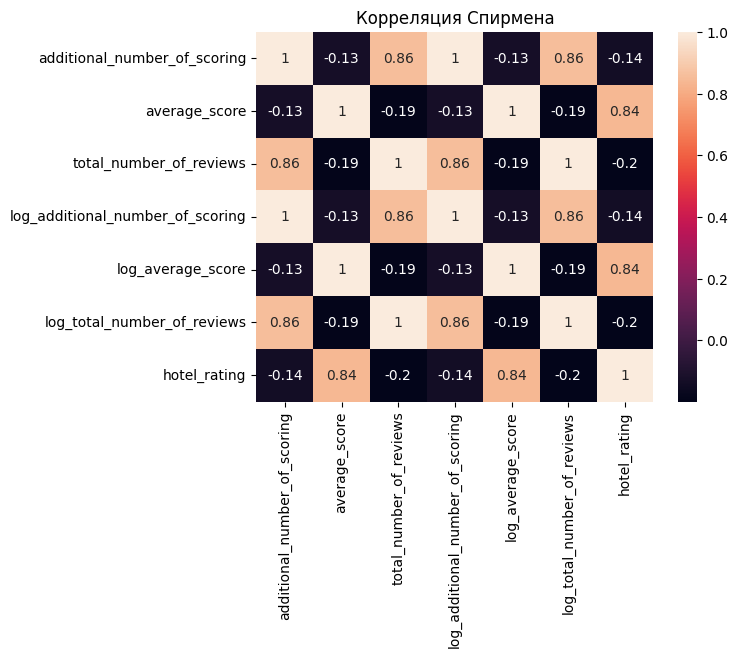

In [104]:
spearman_corr = data[mask].corr(method='spearman')
col_list = []

for column in spearman_corr.columns:
    if abs(spearman_corr[spearman_corr[column] != 1][column].max() > 0.7):
        col_list.append(column)
plt.figure()       
sns.heatmap(spearman_corr[col_list].loc[col_list], annot=True)
plt.title('Корреляция Спирмена');


удалю по одному признаку из пар с коррелляцией больше 0.8, кроме `total_number_of_reviews` и `additional_number_of_scoring` - решение по ним буду смотреть позже опытным путем

In [105]:

drop_cols = ['log_total_number_of_reviews', 'hotel_rating', 'log_additional_number_of_scoring', 'log_average_score']
data = data.drop(drop_cols, axis=1)

In [106]:
drop_cols2 = ['log_review_total_negative_word_counts', 'log_review_total_positive_word_counts', 'log_total_number_of_reviews_reviewer_has_given']
data = data.drop(drop_cols2, axis=1)

In [107]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 512372 entries, 0 to 512371
Data columns (total 62 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                512372 non-null  int64  
 1   average_score                               512372 non-null  float64
 2   review_total_negative_word_counts           512372 non-null  int64  
 3   total_number_of_reviews                     512372 non-null  int64  
 4   review_total_positive_word_counts           512372 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  512372 non-null  int64  
 6   days_since_review                           512372 non-null  int32  
 7   lat                                         512372 non-null  float64
 8   lng                                         512372 non-null  float64
 9   sample                                      512372 non-null  int64  
 

### Выделение тестовой части

In [108]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [109]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

### Оценка значимости признаков.

Разделим признаки по типу на непрерывные и категориальные.

In [110]:
num_cols = ['additional_number_of_scoring', 'review_total_negative_word_counts', 'total_number_of_reviews',
            'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given',
            'days_since_review'] 
            
cat_cols = ['average_score', 'count_nights', 'trip_type', 'trip_pet', 'review_year', 'review_month',
       'review_weekend', 'eq_country', 'real_pos', 'real_neg', 'number_of_reviewer_has_given_bins', 'country_Austria',
       'country_France', 'country_Italy', 'country_Netherlands', 'country_Spain', 'country_United Kingdom',
       'sub-region_Australia and New Zealand', 'sub-region_Central Asia', 'sub-region_Eastern Asia', 'sub-region_Eastern Europe',
       'sub-region_Latin America and the Caribbean', 'sub-region_Melanesia', 'sub-region_Micronesia', 'sub-region_Northern Africa',
       'sub-region_Northern America', 'sub-region_Northern Europe', 'sub-region_Polynesia', 'sub-region_South-eastern Asia',
       'sub-region_Southern Asia', 'sub-region_Southern Europe', 'sub-region_Sub-Saharan Africa', 'sub-region_Western Asia',
       'sub-region_Western Europe', 'neg_features_breakfast', 'neg_features_everything', 'neg_features_expensive',
       'neg_features_location', 'neg_features_room', 'neg_features_staff', 'pos_features_breakfast', 'pos_features_everything',
       'pos_features_location', 'pos_features_room', 'pos_features_staff', 'rooms_type_0', 'rooms_type_1', 'rooms_type_2', 'rooms_type_3',
       'rooms_type_4', 'rooms_type_5', 'rooms_type_6']

Оценим значимость категориальных признаков методом Хи-квадрат.

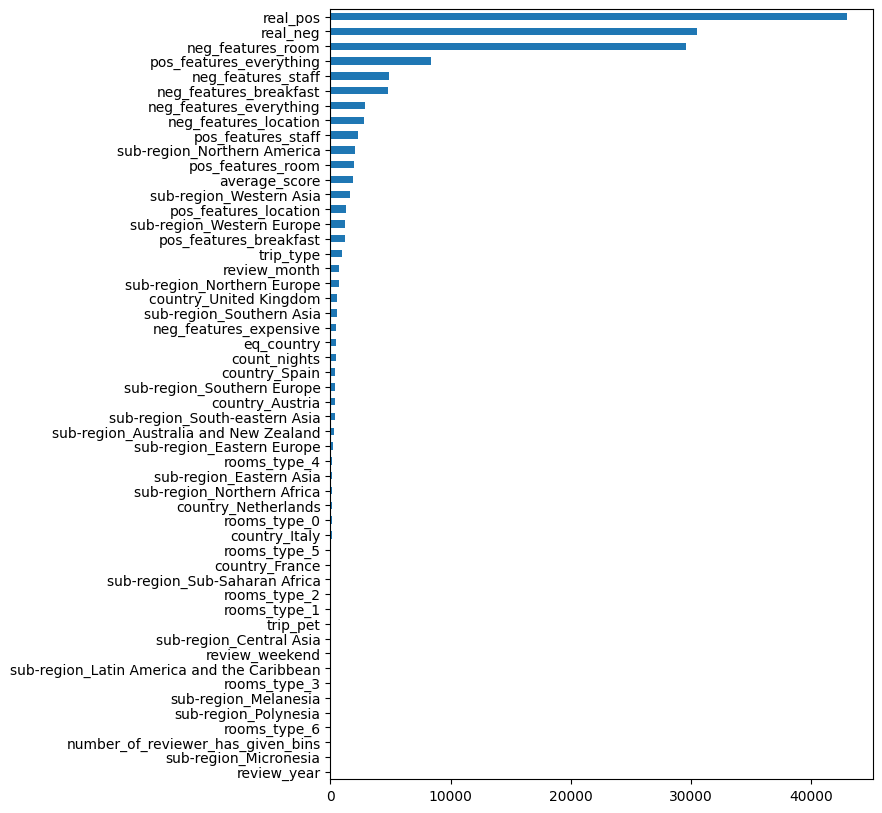

In [111]:
y = y.astype('int')

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh', figsize=(7, 10));

Оценим значимость непрерывных признаков методом ANOVA.

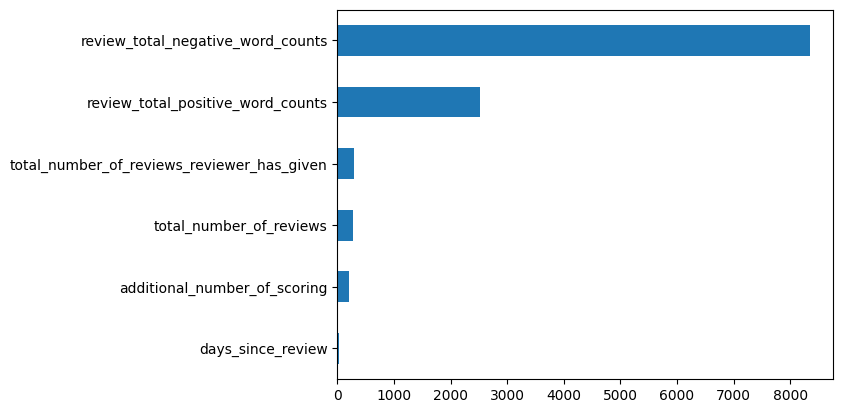

In [112]:
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh');

In [113]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 61), (383437, 61), (383437, 60), (306749, 60), (76688, 60))

In [114]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [115]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.6s finished


In [116]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
#print('MAPE:', mape)

In [117]:
# Функция для вычисления MAPE
def mape_func(Y_actual, Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

print('MAPE', mape_func(y_test, y_pred))

MAPE 12.984722100023438


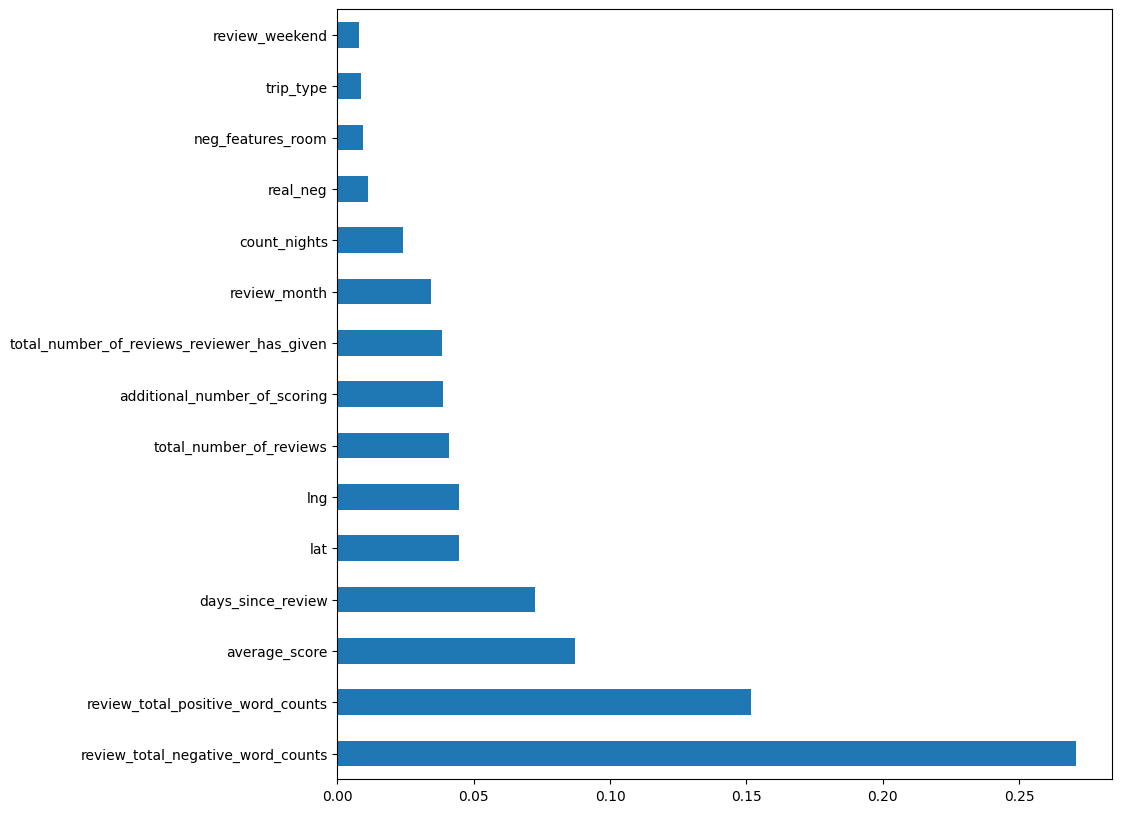

In [118]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh');

In [119]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,reviewer_score,...,pos_features_location,pos_features_room,pos_features_staff,rooms_type_0,rooms_type_1,rooms_type_2,rooms_type_3,rooms_type_4,rooms_type_5,rooms_type_6
68102,487,8.8,0,1805,19,1,198,51.474469,-0.019428,0.0,...,0,1,0,0,0,0,0,0,0,1
85565,61,7.6,16,576,13,2,107,45.461129,9.154267,0.0,...,0,1,0,0,0,0,0,0,0,1
103280,220,9.3,16,831,11,17,247,51.506945,-0.141578,0.0,...,1,0,0,0,0,0,0,0,0,1
29478,38,9.5,0,222,7,3,130,48.860512,2.310653,0.0,...,0,0,0,0,0,0,0,0,0,1
78365,384,9.2,26,4017,121,6,15,45.482669,9.203437,0.0,...,1,0,0,0,0,0,0,0,0,1
53299,126,8.2,9,1281,16,3,269,48.875662,2.286347,0.0,...,0,0,0,0,0,0,0,0,0,1
46260,237,8.4,0,2179,4,1,625,52.310118,4.947292,0.0,...,0,0,0,0,0,0,0,0,0,1
114271,832,9.1,10,4672,13,1,26,51.510237,-0.076443,0.0,...,1,0,0,0,0,0,0,0,0,1
61771,419,8.4,5,4527,8,9,579,41.375029,2.149117,0.0,...,1,0,0,0,0,0,0,0,0,1
443,337,8.9,0,1769,5,3,457,41.393518,2.163981,0.0,...,0,0,0,0,0,0,0,0,0,1


In [120]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [121]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [122]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.0s finished


In [123]:
predict_submission

array([8.661, 6.517, 8.288, ..., 7.712, 9.568, 7.224])

In [124]:
list(sample_submission)

['reviewer_score', 'id']

In [125]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission4.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.661,488440
1,6.517,274649
2,8.288,374688
3,9.360,404352
4,9.475,451596
5,8.766,302161
6,8.433,317079
7,7.535,13963
8,8.813,159785
9,7.714,195089
